## Module 2 Final Project Submission
* Name: Vivienne DiFrancesco
* Pace: Full Time
* Instructor: James Irving

# Introduction

**Goal**: The purpose of this project was to make a linear regression model to predict the sell prices of homes for home owners. 

**Data**: The data used for this project was records of houses sold in King County Washington, which includes the urban center of Seattle. The dataset contained over 21,000 records and included homes priced between $ \$7.7 $ million  and $ \$78,000 $. The houses were sold between 5/2/2014 and 5/27/2015. The data includes information about squarefootage of the homes, condition, floors, year built, renovations, bedrooms, bathrooms, and size of the lot. 

**Audience**: Using the model built, people in King County who are looking to sell their homes can gain insights. The predictions could be helpful for homeowners to get a better price when selling their home or to know what price to expect when selling their home.

**Approach**: In this project I will be aiming for interpretability of the model so as to be able to make sense of coefficients and pull recommendations out that people can easily understand. Because of that, aspects of model quality my suffer since there are some measures of transforming of the data which are not appropriate. My approach will also include modeling results after each change of the data to note how the model improves or declines from the change. I followed the OSEMiN data science workflow for this project.


# Obtaining the data

In [1]:
# Importing libraries that I will use
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
%matplotlib inline

# Setting default seaborn setting for my visuals
sns.set(style="whitegrid")

# Supressing warnings
import warnings
warnings.filterwarnings('ignore')

# Importing the statsmodels packages I will use
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing scikit learn packages I will use
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [2]:
# Setting pandas to display max columns and rows
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', None)

# Turning off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# Loading in the data
df = pd.read_csv('Data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,nan,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


In [4]:
# Set the index to the id
df.set_index('id', inplace=True)

In [5]:
# Checking out the length and columns
df.shape

(21597, 20)

In [6]:
# Checking the data types and where there might be nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.5+ MB


# Scrubbing the data

## Addressing the price column

I started with the price column since that is the target. I wanted to get to know the data a little using describe(). I looked at value_counts() to make sure there weren't issues with rogue values like 0000 or something that would not register as nulls.

In [7]:
# Making price an integer instead of a float
df.price = df.price.astype('int64')

In [8]:
# Checking the stats for the column to see if everything looks normal
df.price.describe()

count     21597.000
mean     540296.574
std      367368.140
min       78000.000
25%      322000.000
50%      450000.000
75%      645000.000
max     7700000.000
Name: price, dtype: float64

In [9]:
# Double checking that there aren't rogue values hiding in the data
df.price.value_counts()[:20]

450000    172
350000    172
550000    159
500000    152
425000    150
325000    148
400000    145
375000    138
300000    133
525000    131
250000    130
475000    120
330000    119
650000    117
275000    113
415000    111
315000    111
600000    110
390000    110
280000    109
Name: price, dtype: int64

## Dealing with NA values

I then turned to the other columns to deal with NA values. I filled the NA values, cast them to the correct data type, and then used value_counts() to check for rogue entries that may have been missed.

In [10]:
# Looking at all NA values in all columns
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

> I tried mapping the entries that were missing waterfront and it seems as if some of the entries would be waterfront properties. I decided to fill the null values based on the ratio of 0 and 1 that are already in the dataset.

In [11]:
# Creating a sub-dataframe of the missing entries to use for visualizing
waterfront_check = df.copy()
waterfront_check = waterfront_check[waterfront_check['waterfront'].isna()]
# Saved the file in Data folder as waterfront_check.csv

This map was created using the "waterfront_check" data (located in the Data folder of this repo) loaded into Tableau Public. This screenshot is a zoomed in view to better see individual entries as an example. The full image can be viewed and downloaded from https://public.tableau.com/profile/vivienne4370 

<img src="Visuals/waterfrontcheck.png">

In [12]:
# Checking the percentages of the different values
df.waterfront.value_counts(normalize=True)

0.000   0.992
1.000   0.008
Name: waterfront, dtype: float64

In [13]:
# Checking value counts before filling the missing values
df.waterfront.value_counts()

0.000    19075
1.000      146
Name: waterfront, dtype: int64

In [14]:
# Setting the probability ratios based on the value counts
prob = df.waterfront.value_counts(normalize=True).values

# Setting a seed so that the random results are the same every time
np.random.seed(123)

# Filling the missing values with either 0 or 1 using the probability
df["waterfront"] = df["waterfront"].apply(lambda x: 
                                          np.random.choice([0, 1], p=prob) 
                                          if (np.isnan(x)) else x)

In [15]:
# Making sure the value counts changed appropriately 
# and there are no nulls left
df["waterfront"].value_counts(normalize=True, dropna=False)

0.000   0.992
1.000   0.008
Name: waterfront, dtype: float64

In [16]:
# Changing the datatype
df.waterfront = df.waterfront.astype('int64')

> I dropped the view column since it is not clear what this data represents. It does not represent the views from the house but likely has something to do with listing views. Without knowing what it could mean, I dropped it to avoid any confusion from the column.

In [17]:
# Filling NA values with 0
df.drop(columns='view', inplace=True)

> I decided to fill the yr_renovated columns with zeros and just assume that if the value is null that it means the house has not been renovated.

In [18]:
# Filling NA values with 0
df.yr_renovated.fillna(0, inplace=True)

In [19]:
# Checking for rogue values
df.yr_renovated.value_counts()

0.000       20853
2014.000       73
2003.000       31
2013.000       31
2007.000       30
2000.000       29
2005.000       29
1990.000       22
2004.000       22
2009.000       21
1989.000       20
2006.000       20
2002.000       17
1991.000       16
1998.000       16
1984.000       16
1999.000       15
2008.000       15
2010.000       15
2001.000       15
1983.000       15
2015.000       14
1985.000       14
1986.000       14
1987.000       14
1994.000       14
1992.000       13
1993.000       12
1997.000       12
1995.000       12
1996.000       11
1988.000       11
1970.000        9
2011.000        9
1980.000        8
1982.000        8
2012.000        8
1979.000        7
1977.000        7
1968.000        7
1975.000        5
1964.000        5
1969.000        4
1963.000        4
1973.000        4
1981.000        4
1965.000        4
1978.000        3
1960.000        3
1958.000        3
1956.000        3
1955.000        3
1945.000        3
1972.000        3
1967.000        2
1957.000  

In [20]:
# Changing the datatype
df.yr_renovated = df.yr_renovated.astype('int64')

In [21]:
# Verifying that all NAs were dealt with
df.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Checking for strange values in other columns

I looked through the rest of my columns for rogue entries and to generally better get to know my data.

In [22]:
# Looking at columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 19 columns):
date             21597 non-null object
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(4), int64(13), object(2)
memory usage: 3.3+ MB


In [23]:
# Checking for any strange values
df.date.value_counts()[:10]

6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
3/25/2015    123
4/14/2015    121
4/22/2015    121
4/28/2015    121
7/9/2014     121
Name: date, dtype: int64

> There is an entry with 33 bedrooms. I'm going to leave it for now and deal with it later when I do outlier removal.

In [24]:
# Checking for any strange values
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [25]:
# Checking for any strange values
df.bathrooms.value_counts()

2.500    5377
1.000    3851
1.750    3048
2.250    2047
2.000    1930
1.500    1445
2.750    1185
3.000     753
3.500     731
3.250     589
3.750     155
4.000     136
4.500     100
4.250      79
0.750      71
4.750      23
5.000      21
5.250      13
5.500      10
1.250       9
6.000       6
5.750       4
0.500       4
8.000       2
6.250       2
6.750       2
6.500       2
7.500       1
7.750       1
Name: bathrooms, dtype: int64

In [26]:
# Checking for any strange values
df.sqft_living.value_counts()[:20]

1300    138
1400    135
1440    133
1660    129
1010    129
1800    129
1820    128
1480    125
1720    125
1540    124
1560    124
1320    122
1250    120
1580    119
1200    118
1370    118
1650    117
1900    117
1780    117
1680    116
Name: sqft_living, dtype: int64

In [27]:
# Checking for any strange values
df.sqft_lot.value_counts()[:20]

5000    358
6000    290
4000    251
7200    220
7500    119
4800    119
4500    114
8400    111
9600    109
3600    103
9000     93
3000     84
5100     78
7000     76
8000     76
5500     73
8100     72
7800     69
4080     67
7700     66
Name: sqft_lot, dtype: int64

In [28]:
# Checking for any strange values
df.floors.value_counts()

1.000    10673
2.000     8235
1.500     1910
3.000      611
2.500      161
3.500        7
Name: floors, dtype: int64

In [29]:
# Checking for any strange values
df.condition.value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [30]:
# Checking for any strange values
df.grade.value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [31]:
# Checking for any strange values
df.sqft_above.value_counts()[:20]

1300    212
1010    210
1200    206
1220    192
1140    184
1400    180
1060    178
1180    177
1340    176
1250    174
1320    172
1100    164
1080    161
1040    160
1240    160
1150    159
1330    158
1260    155
1440    155
1120    154
Name: sqft_above, dtype: int64

> There are question mark values for sqft_basement. I decided to fill them with zeros.

In [32]:
# Checking for any strange values
df.sqft_basement.value_counts()[:20]

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
300.0       142
900.0       142
200.0       105
750.0       104
530.0       103
480.0       103
450.0       103
720.0        98
620.0        90
580.0        84
840.0        83
420.0        81
Name: sqft_basement, dtype: int64

In [33]:
# Replacing the ? entries with 0
df.sqft_basement = df.sqft_basement.map(lambda x: 
                                        int(float(x.replace('?', '0'))))

In [34]:
# Setting the datatype to be an integer
df.sqft_basement = df.sqft_basement.astype('int64')

In [35]:
# Checking for any strange values again
df.sqft_basement.value_counts()[:20]

0       13280
600       217
500       209
700       208
800       201
400       184
1000      148
900       142
300       142
200       105
750       104
530       103
480       103
450       103
720        98
620        90
580        84
840        83
420        81
860        79
Name: sqft_basement, dtype: int64

In [36]:
# Checking for any strange values
df.yr_built.value_counts()[:20]

2014    559
2006    453
2005    450
2004    433
2003    420
2007    417
1977    417
1978    387
1968    381
2008    367
1967    350
1979    343
1959    334
1990    317
1962    312
2001    305
1954    305
1987    294
1989    290
1969    280
Name: yr_built, dtype: int64

In [37]:
# Checking for any strange values
df.zipcode.value_counts()[:20]

98103    602
98038    589
98115    583
98052    574
98117    553
98042    547
98034    545
98118    507
98023    499
98006    498
98133    493
98059    468
98058    455
98155    446
98074    441
98033    432
98027    412
98125    409
98056    406
98053    403
Name: zipcode, dtype: int64

In [38]:
# Checking for any strange values
df.lat.value_counts()

47.662    17
47.549    17
47.532    17
47.685    17
47.671    16
47.689    16
47.696    16
47.665    15
47.690    15
47.686    15
47.684    15
47.540    15
47.552    14
47.685    14
47.543    14
47.532    14
47.540    14
47.673    14
47.544    14
47.684    14
47.673    14
47.708    14
47.553    14
47.665    14
47.691    14
47.637    14
47.534    14
47.653    14
47.540    14
47.682    14
47.531    13
47.566    13
47.675    13
47.686    13
47.692    13
47.688    13
47.697    13
47.550    13
47.697    13
47.676    13
47.637    13
47.629    13
47.680    13
47.668    13
47.698    13
47.697    13
47.639    13
47.654    12
47.568    12
47.540    12
47.543    12
47.691    12
47.517    12
47.699    12
47.773    12
47.695    12
47.703    12
47.551    12
47.623    12
47.722    12
47.689    12
47.638    12
47.733    12
47.630    12
47.729    12
47.637    12
47.687    12
47.669    12
47.515    12
47.685    12
47.512    12
47.563    12
47.634    12
47.571    12
47.533    12
47.674    12
47.552    12

In [39]:
# Checking for any strange values
df.long.value_counts()

-122.290    115
-122.300    111
-122.362    104
-122.291    100
-122.372     99
-122.363     99
-122.288     98
-122.357     96
-122.284     95
-122.172     94
-122.365     94
-122.306     93
-122.346     93
-122.351     92
-122.304     92
-122.348     92
-122.299     92
-122.375     92
-122.295     91
-122.350     90
-122.285     90
-122.292     90
-122.352     89
-122.289     89
-122.298     88
-122.359     88
-122.384     87
-122.317     86
-122.316     86
-122.301     86
-122.354     85
-122.287     85
-122.361     85
-122.391     85
-122.353     85
-122.385     84
-122.311     84
-122.189     83
-122.371     83
-122.286     83
-122.378     81
-122.370     81
-122.388     81
-122.349     81
-122.340     80
-122.387     79
-122.331     78
-122.358     78
-122.308     78
-122.307     78
-122.337     77
-122.360     76
-122.356     76
-122.297     76
-122.369     75
-122.319     75
-122.174     75
-122.339     75
-122.324     75
-122.302     75
-122.321     74
-122.379     74
-122.315

In [40]:
df.sqft_living15.value_counts()[:20]

1540    197
1440    195
1560    192
1500    180
1460    169
1580    167
1610    166
1800    166
1720    166
1620    164
1510    164
1760    163
1480    160
1410    159
1550    158
1820    157
1680    157
1670    157
1520    155
1660    155
Name: sqft_living15, dtype: int64

In [41]:
df.sqft_lot15.value_counts()[:20]

5000    427
4000    356
6000    288
7200    210
4800    145
7500    142
8400    116
4500    111
3600    111
5100    109
4080    106
8000    105
9600     98
8100     93
9000     92
7800     86
7700     85
5500     81
5400     71
6600     68
Name: sqft_lot15, dtype: int64

In [42]:
# Final check that all the data types are good
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 19 columns):
date             21597 non-null object
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(4), int64(14), object(1)
memory usage: 3.3+ MB


## Adding Columns

There are some columns I want to add based on the data I have in other columns that I think may be of more use to my model than the current columns. For example the sqft_basement column has mostly 0 entries. It may be more useful to have a column that indicates whether a basement exists or not. Also with dates, it may be useful to have columns based on month or season sold.

In [43]:
# Spliting the month out of the date column into a new column of its own
df['month_sold'] = df['date'].map(lambda x: x.replace('/', ' ').split()[0])

In [44]:
# Casting the new column to be an integer
df['month_sold'] = df['month_sold'].astype('int64')

In [45]:
# Checking the values of the new column
df.month_sold.value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month_sold, dtype: int64

In [46]:
# Function that takes the day from the date column 
# and assigns a week of the month

def week_of_month(x):
#     Splitting the day out from the date
    day = int(x.replace('/', ' ').split()[1])
    
#     Assigning the week based on the day
    if day < 8:
        week = 1
    elif day < 15 and day > 7:
        week = 2
    elif day < 22 and day > 14:
        week = 3
    elif day < 29 and day > 21:
        week = 4
    else:
        week = 5
        
    return week

In [47]:
# Adding the new column by applying the function above
df['week_sold'] = df['date'].map(week_of_month)

In [48]:
# Checking the values of the new column
df.week_sold.value_counts()

4    5212
2    5093
3    4934
1    4839
5    1519
Name: week_sold, dtype: int64

In [49]:
# Function that takes the month sold and assigns the month to a season

def season_sold(x):
    
#     Assigning season based on month
    if x > 2 and x < 6:
        season = 1
    elif x > 5 and x < 9:
        season = 2
    elif x > 8 and x < 12:
        season = 3
    else:
        season = 4
        
    return season

In [50]:
# Creating the new column by applying the function above
df['season_sold'] = df['month_sold'].map(season_sold)

In [51]:
# Checking the values of the new column
df.season_sold.value_counts()

1    6518
2    6328
3    5056
4    3695
Name: season_sold, dtype: int64

In [52]:
# Creating new renovated column
df['was_renovated'] = df['yr_renovated'].map(lambda x: x!=0)

In [53]:
# Casting the new column to be an integer
df['was_renovated'] = df['was_renovated'].astype('int64')

In [54]:
# Checking the values of the new column
df.was_renovated.value_counts()

0    20853
1      744
Name: was_renovated, dtype: int64

In [55]:
# Creating new basement column
df['has_basement'] = df['sqft_basement'].map(lambda x: x!=0 )

In [56]:
# Casting the new column to be an integer
df['has_basement'] = df['has_basement'].astype('int64')

In [57]:
# Checking the values of the new column
df.has_basement.value_counts()

0    13280
1     8317
Name: has_basement, dtype: int64

In [58]:
# Dropped the date column since the values will be hard to model with
df.drop(columns='date', inplace=True)

In [59]:
# Checking all my columns at data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 23 columns):
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
month_sold       21597 non-null int64
week_sold        21597 non-null int64
season_sold      21597 non-null int64
was_renovated    21597 non-null int64
has_basement     21597 non-null i

# Exploring the data

## EDA Question 1: How does location affect house prices, sizes, and other metrics? 

I was curious to do some exploration with the latitude and longitude to map the houses and look at various factors like price, home square footage, and lot square footage. The visuals here were created using my cleaned data loaded into Tableau Public. The full images can be viewed and downloaded from https://public.tableau.com/profile/vivienne4370

In [60]:
# Saved the cleaned dataframe in Data folder as cleaned_data.csv

### Location and price

<img src="Visuals/Home Prices By Location.png">

<img src="Visuals/Median Home Price By Zipcode.png">

> These maps show that the areas around Seattle and Bellevue are the most expensive. I am surprised that Bellevue is actually more expensive than Seattle. In general though the trend is that the closer to the urban center, then the more expensive. Which is a trend I expected.

### Location and squarefootage

<img src="Visuals/Squarefoot Lot By Location.png">

<img src="Visuals/Squarefoot Living Space By Location.png">

> As expected the lot size increases the further out you get from the urban center. However, I am surprised to see that in the Bellevue area there are homes with some larger lots. Home squarefootage also surprises me that there are some very large homes in the urban center. I would expect the homes to have more of a trend of being larger the further you get out from the city. That is somewhat the case, but not as dramatically as I would expect.

### Location and home age

<img src="Visuals/Year Built By Location.png">

> This visualization shows the clear trend of the oldest homes being in the urban center and how houses were built out from there over time. It's interesting to see the smattering of newer homes in the urban center and pockets of older homes on the outskirts. It would be interesting to know more of the history of these old homes.

## Checking the distribution of prices

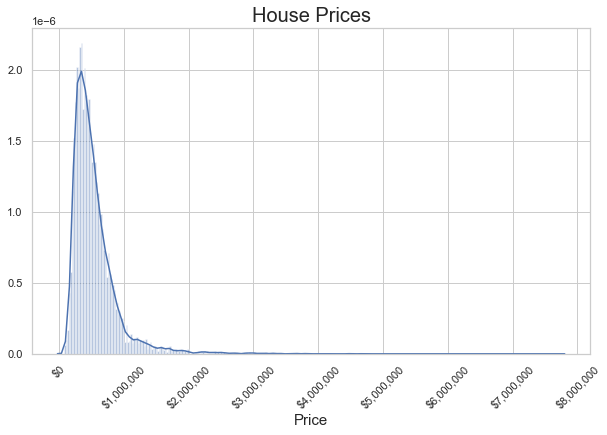

In [61]:
# Setting the figure and plotting
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(df['price'], bins='auto')

# Adjusting the money ticks 
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.xaxis.set_major_formatter(tick_money)
plt.xticks(rotation=45)

# Setting the title and labels
ax.set_xlabel('Price', fontsize=15)
ax.set_title('House Prices', fontsize=20);

>There is a large tail to the distribution of prices which is to be expected since there are of course a few houses that are much more expensive than the majority of houses. I will address all the outliers at a later point, but it's good to see that there looks to still be good normality in the prices despite the long tail.

## Checking linearity, normality distribution, and choosing categorical columns

In [62]:
# Creating a function to plot a single feature against price
def explore_plot(df, col, target='price'):
    
#     Plotting the graph and setting the regression line to be red
    g = sns.jointplot(data=df, x=col, y=target, kind='reg', height=6, 
                      joint_kws={'line_kws':{'color':'red'}})

#     Setting the title
    plt.suptitle(f'{col} and {target}', fontsize=20, y=1.05)
    return g

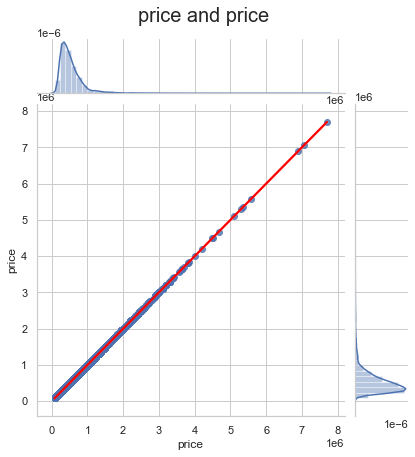

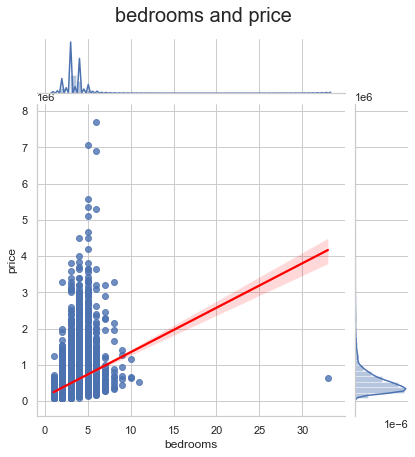

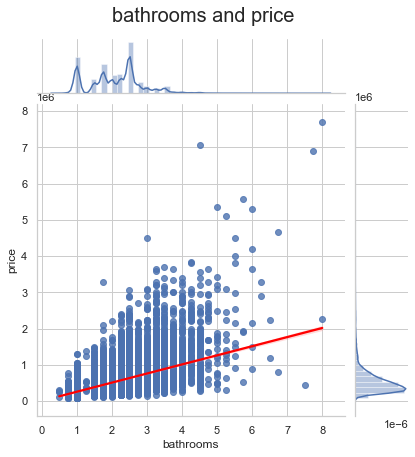

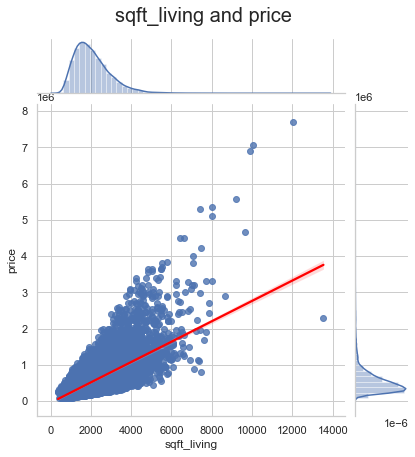

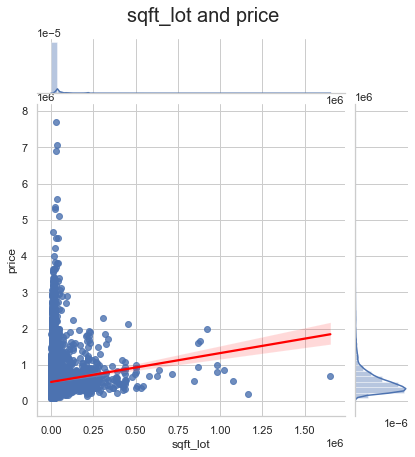

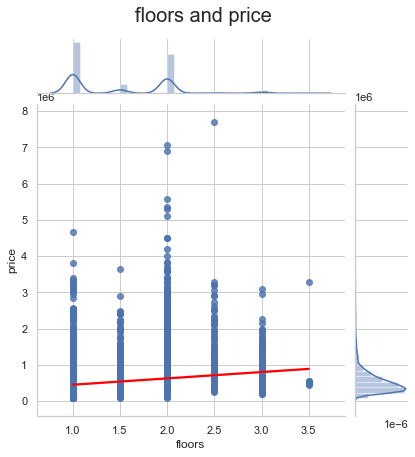

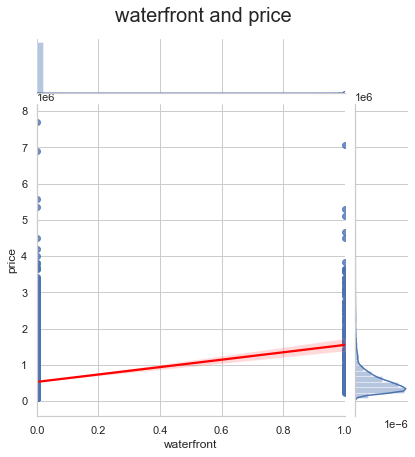

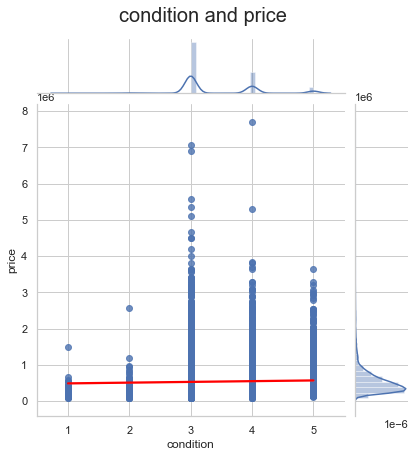

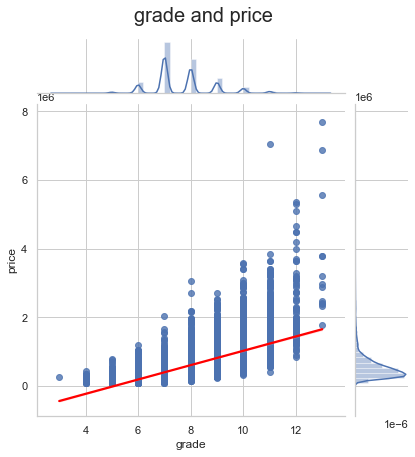

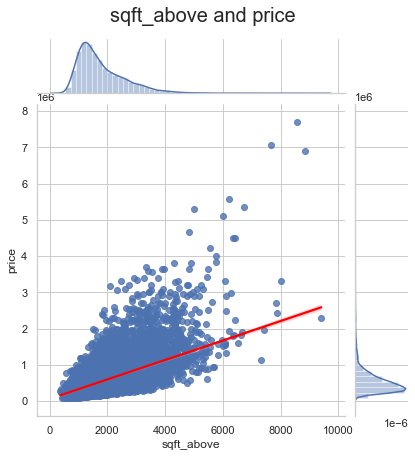

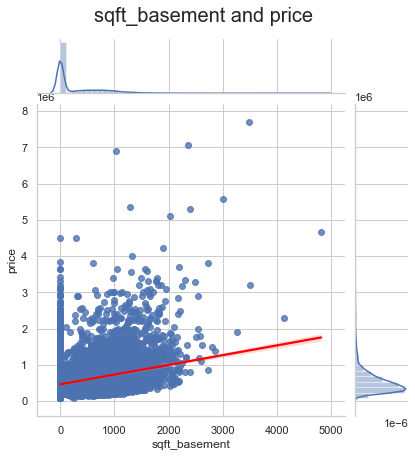

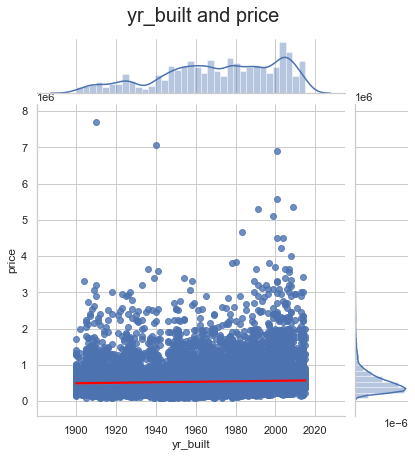

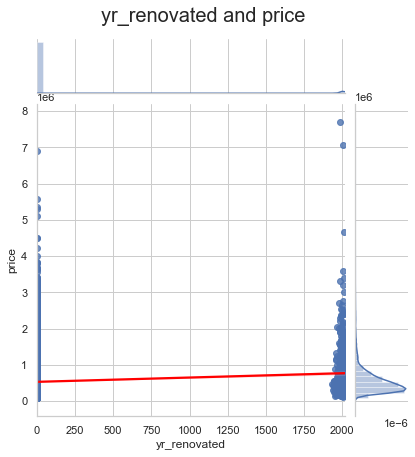

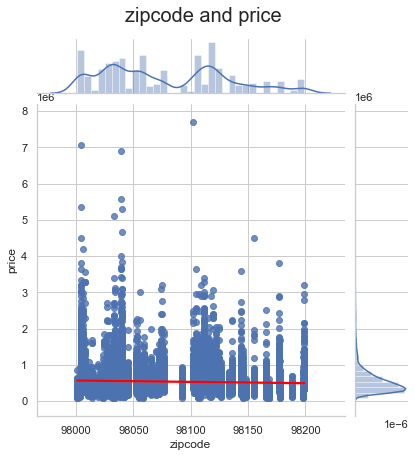

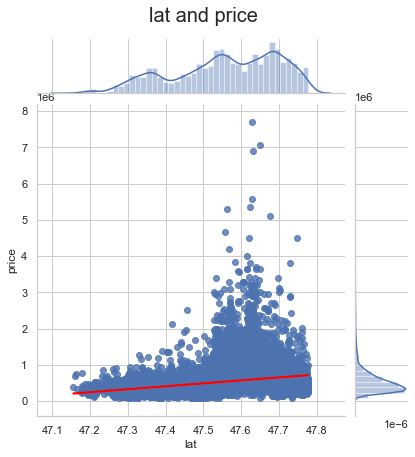

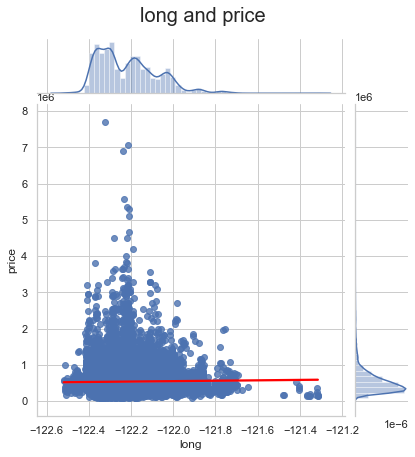

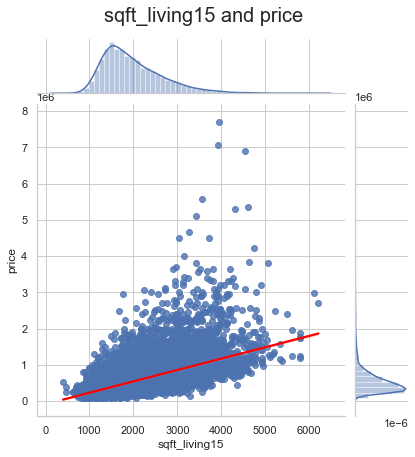

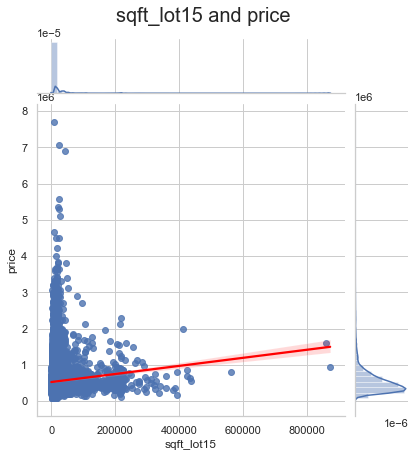

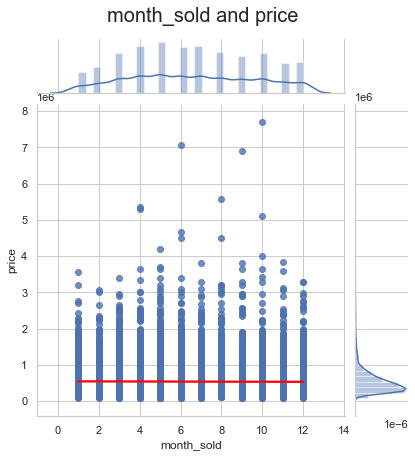

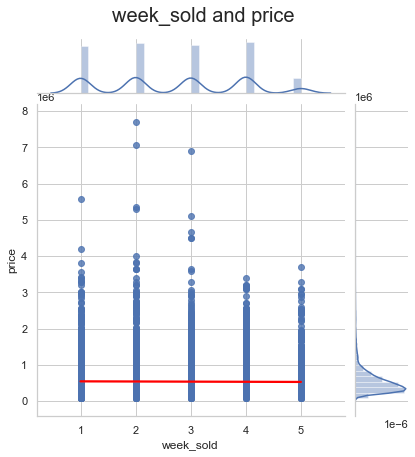

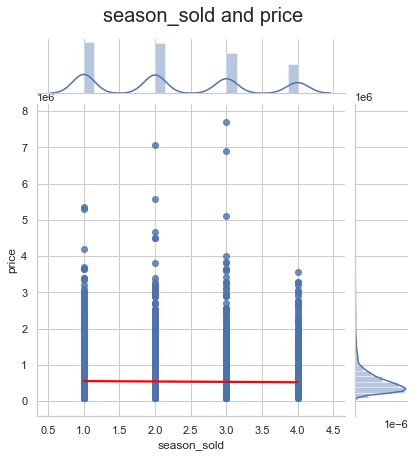

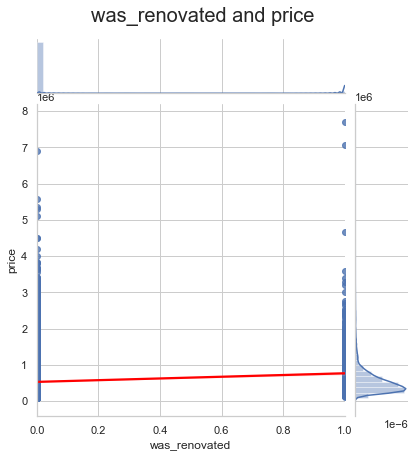

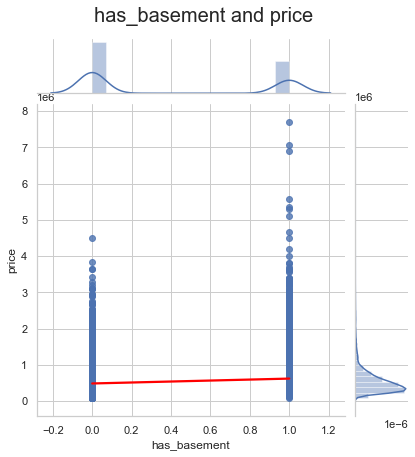

In [63]:
# Looping through the columns to feed each into the function above
cols = list(df.columns)
for col in cols:
    explore_plot(df, col)

> Based on these graphs, I decided to make condition, zipcode, month_sold, week_sold, and season_sold categorical features. I want to turn yr_built into a category as well since there is no linearity in the relationship. Others have a very weak linear relationship, but I will leave them for now with my first model and judge them by the p-values later. There are many features that also do not have normality or have a lot of outliers which I will address for other models. For this first model I want to leave the data as is to better judge improvements.

In [64]:
categories = ['condition', 'zipcode','month_sold', 'week_sold', 'season_sold']
for col in categories:
    df[col] = df[col].astype('category')

## Making year built categorical

In [65]:
df.yr_built.describe()

count   21597.000
mean     1971.000
std        29.375
min      1900.000
25%      1951.000
50%      1975.000
75%      1997.000
max      2015.000
Name: yr_built, dtype: float64

In [66]:
# Funcation that takes the year built and puts it into a bucket for decade

def built_decades(x):
#     Assigning the decade built

    if x < 1910:
        decade = 0
    elif x < 1920 and x > 1909:
        decade = 1
    elif x < 1930 and x > 1919:
        decade = 2
    elif x < 1940 and x > 1929:
        decade = 3
    elif x < 1950 and x > 1939:
        decade = 4
    elif x < 1960 and x > 1949:
        decade = 5
    elif x < 1970 and x > 1959:
        decade = 6
    elif x < 1980 and x > 1969:
        decade = 7
    elif x < 1990 and x > 1979:
        decade = 8
    elif x < 2000 and x > 1989:
        decade = 9
    elif x < 2010 and x > 1999:
        decade = 10
    else:
        decade = 11
    return decade

In [67]:
# Mapping the function to the column to change the values
df['yr_built'] = df['yr_built'].map(built_decades)

In [68]:
df['yr_built'] = df['yr_built'].astype('category')

In [69]:
# Checking that the values changed
df.yr_built.value_counts()

10    3515
6     2658
5     2450
7     2285
8     2281
9     2232
4     1763
11    1241
2     1192
1      805
0      645
3      530
Name: yr_built, dtype: int64

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 23 columns):
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
condition        21597 non-null category
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null category
yr_renovated     21597 non-null int64
zipcode          21597 non-null category
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
month_sold       21597 non-null category
week_sold        21597 non-null category
season_sold      21597 non-null category
was_renovated    21597 non-null int64
has_basement   

## EDA Question 2: What are the average home prices for the categorical features?

Now that I have my categorical features picked, I wanted to look more closely at how they affect home prices. I decided to plot them all to see what kinds of interesting trends I would find.

In [71]:
# Function that plots each of the categorical features
def plot_categories(df):
    
#     Loops through the category data types
    for col in df.select_dtypes('category'):
        
#       Creating the figure and setting the fig size
        fig, ax = plt.subplots(figsize=(10,6))
    
#       Plotting each column at a time
        sns.barplot(x=col, y='price', data=df, palette="husl")
    
#       Setting the title and formatting the x-ticks for better visibility
        ax.set_title(f"{col} vs Price", fontsize=30)
        plt.xticks(rotation=45)
        plt.show()

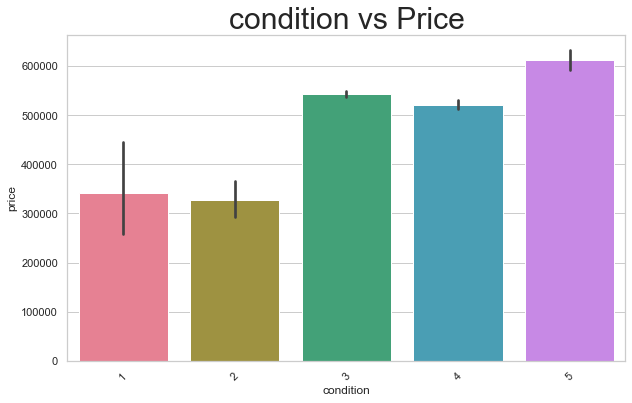

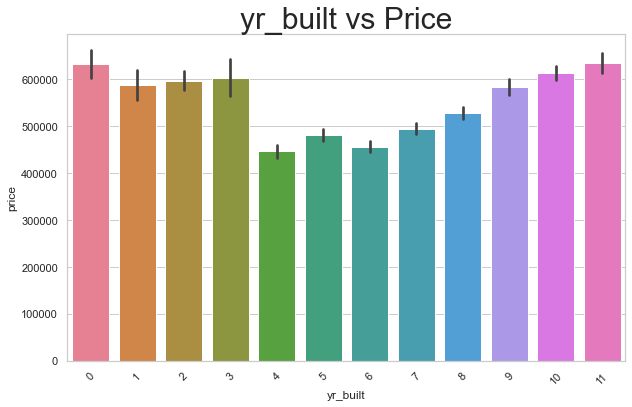

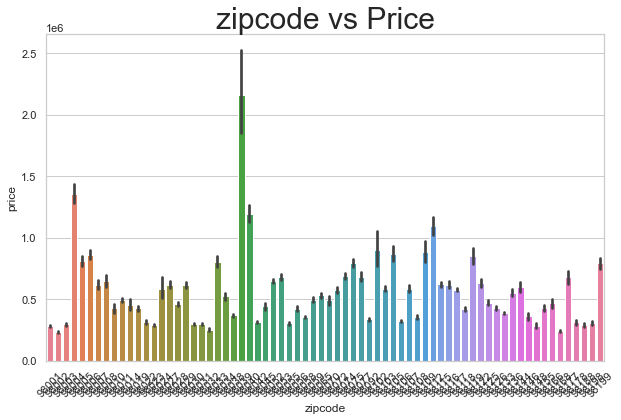

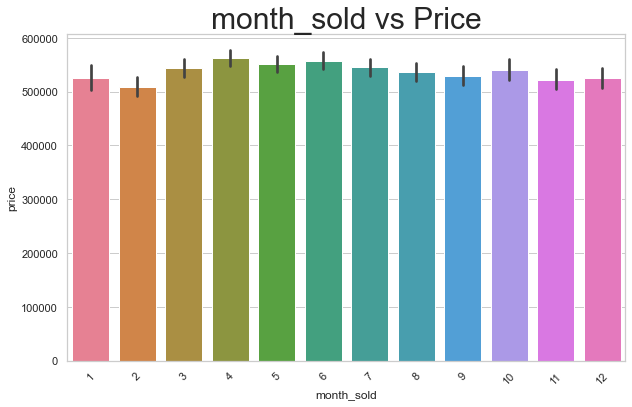

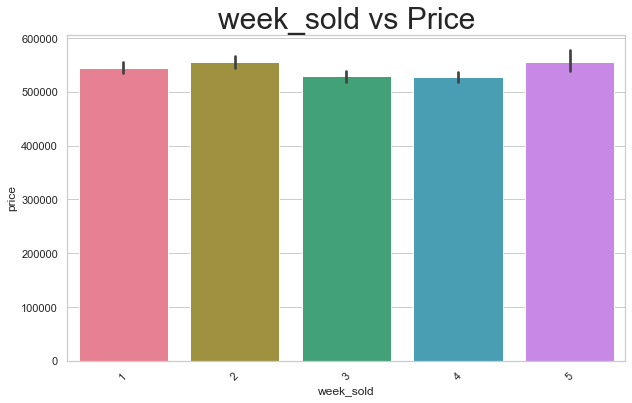

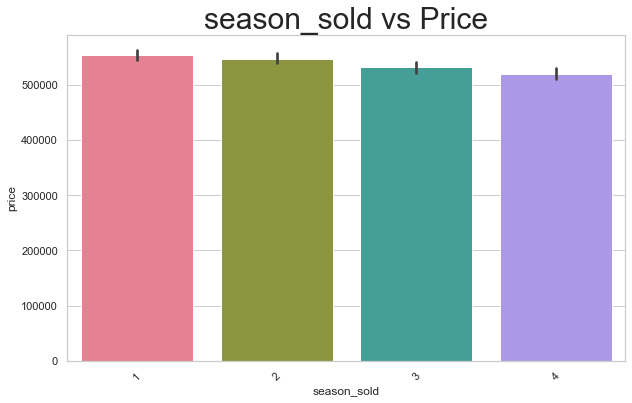

In [72]:
plot_categories(df)

> From these graphs there are some interesting insights:
* Condition shows that there is a division between a category of 1 or 2 and a category of 3, 4, or 5. One would expect a more linear relationship here, but it seems that it has created two buckets of lower and higher condition.
* Year built is interesting that it shows a drop in price starting for houses in the 40s. I expected this to be a linear relationship but from this graph I would guess that many of the very oldest homes are desired for their uniqueness and perhaps certain craftsmanship that is iconic to the era. Then starting for houses built in the 40s, houses are not seen as iconic and charming anymore, and the newer the house the better. 
* The zipcode graph shows pretty much the same thing as the visual from before. There are huge differences in price based on zipcode.
* I was expecting to see a greater difference among the graphs for month, week, and season sold. Winter has a slightly lower average price and February is the worst month. I was also expecting to see a bigger trend with the weeks that maybe it was better to sell a house and the beginning or very end of the month for example. It's interesting to see that the time of selling doesn't make as big of a difference as I thought it would.

# Model 1

## Preparing the data for modeling

I made a dataframe specifically for modeling to leave my original clean dataframe untouched. I decided to drop latitude and longitude for modeling as zipcode will be a more meaningful location feature.

In [73]:
# Creating new modeling dataframe
model1_df = df.copy()

# Dropping columns
model1_df.drop(columns=['lat', 'long'], inplace=True)

In [74]:
# Checking the new dataframe
model1_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,month_sold,week_sold,season_sold,was_renovated,has_basement
id,,,,,,,,,,,,,,,,,,,,,
7129300520,221900,3,1.000,1180,5650,1.000,0,3,7,1180,0,5,0,98178,1340,5650,10,2,3,0,0
6414100192,538000,3,2.250,2570,7242,2.000,0,3,7,2170,400,5,1991,98125,1690,7639,12,2,4,1,1
5631500400,180000,2,1.000,770,10000,1.000,0,3,6,770,0,3,0,98028,2720,8062,2,4,4,0,0
2487200875,604000,4,3.000,1960,5000,1.000,0,5,7,1050,910,6,0,98136,1360,5000,12,2,4,0,1
1954400510,510000,3,2.000,1680,8080,1.000,0,3,8,1680,0,8,0,98074,1800,7503,2,3,4,0,0


In [75]:
# Checking the new dataframe
model1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 21 columns):
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
condition        21597 non-null category
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null category
yr_renovated     21597 non-null int64
zipcode          21597 non-null category
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
month_sold       21597 non-null category
week_sold        21597 non-null category
season_sold      21597 non-null category
was_renovated    21597 non-null int64
has_basement     21597 non-null int64
dtypes: category(6), float64(2), int64(13)
memory usage: 

## Writing the modeling function

In [76]:
# Function that will run my model and some diagnostics
def make_model(df, target='price', test_size=0.25, cv=20):

#     Definging X and y
    X = df.drop([target], axis=1)
    y = df[[target]]
    
#     Performing a train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=123)
    
#     Creating dataframes with the split data
    df_train = pd.concat([y_train, X_train], axis=1)
    df_test = pd.concat([y_test, X_test], axis=1)
    
#     Pulling out the categorical columns
    cat_cols = df_train.select_dtypes('category').columns
    
#     Writing the formula to feed into my model
    features = '+'.join(df_train.drop(columns=target).columns)
    
#     Looping through the categoricals to format the formula correctly
    for col in cat_cols:
        features = features.replace(col,f'C({col})')
        
#     The completed formula to feed in to the model    
    formula = target + '~' + features
    
#     Putting my training data through the model
    model = smf.ols(formula, df_train).fit()
    
#     Plotting a qq plot of the residuals to check for normality
    fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
    sm.graphics.qqplot(model.resid, fit=True, line='45', ax=axes[0])
    axes[0].set_title('QQ Plot Normality Check', fontsize=20)
    
#     Plotting the residuals to check for homoscedasticity 
    ax=axes[1]
    ax.scatter(df_train['price'], model.resid)
    ax.axhline(0, color='red')
    axes[1].set_title('Homoscedasticity Check', fontsize=20)
    
#   This will make both plots appear
    plt.show();

#     Getting the predicted y values from the model
    y_predicted = model.predict(X_test)
    
#     Plotting a scatterplot of the predicted vs actual test data prices 
#     to visually inspect how different they are
    plt.figure(figsize=(20,5))
    
#     Plotting the first 200 entries of the predicted and actual prices
    g = sns.scatterplot(range(len(y_predicted[:200])), y_predicted[:200], 
                        label='Predicted Prices')
    g = sns.scatterplot(range(len(y_test[:200])), y_test.price[:200], 
                        label='Actual Prices')

#     Setting the title, labels, and legend of the plot
    plt.title('Comparison of predicted vs actual price', 
              fontdict={'fontsize':20})
    plt.xlabel('Values')
    plt.ylabel('Prices')
    plt.legend()
    plt.show();
    
#   Getting the r2 for the test data to compare to the train data 
    r2_test = r2_score(y_test, y_predicted)
    print('Model test data R2 score:', r2_test)
    
#   Doing a cross validation k-fold
    cv_result = np.mean(cross_val_score(linreg, X, y, cv=cv, 
                                        scoring='neg_mean_squared_error'))
    print('K-fold cross validation negative MSE:', cv_result)
    
#   Finally, displaying the model summary
    display(model.summary())
    
#   The model is the object returned so I can perform different functions on it
    return model

## Results

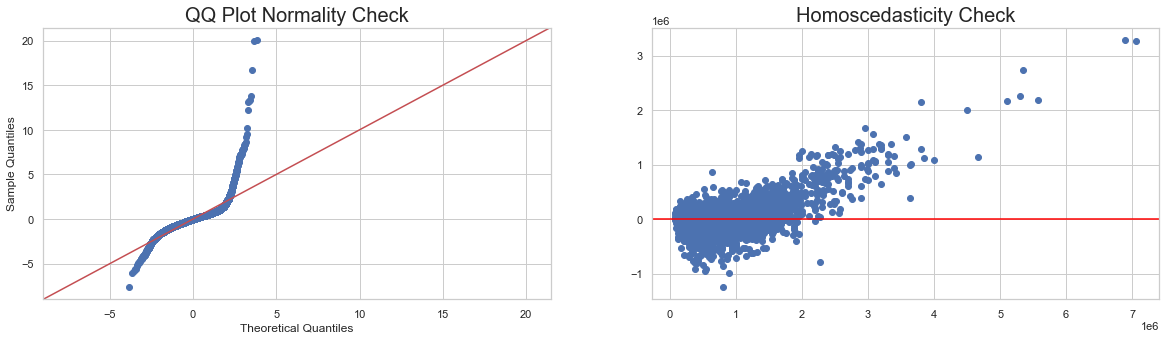

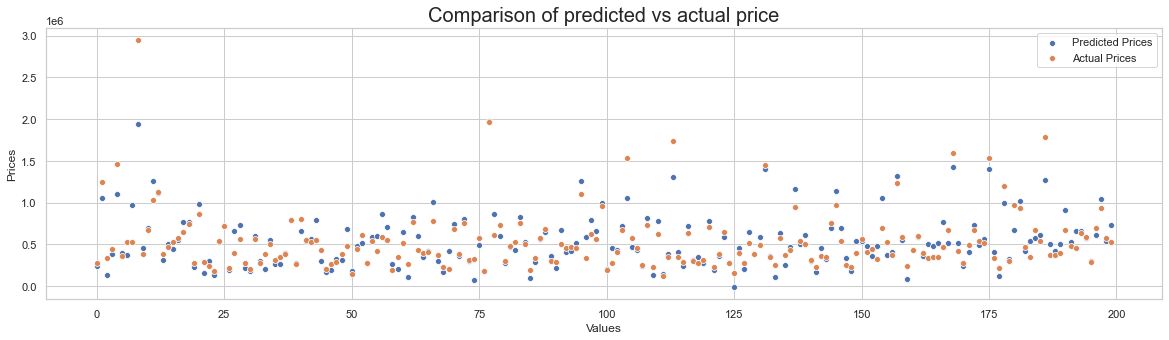

Model test data R2 score: 0.7833876948416307
K-fold cross validation negative MSE: -48299549437.20793


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     576.3
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:46:30   Log-Likelihood:            -2.1746e+05
No. Observations:               16197   AIC:                         4.352e+05
Df Residuals:                   16083   BIC:                         4.360e+05
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -3.9e+05   3.19e+04    -12.217      0.000   -4.53e+05   -3.27e+05
C(condition)[T.2]    3.031e+04    3.7e+04      0.819      0.413   -4.22e+04    1.03e+05
C(condition)[T.3]    1.329e+04   3.39e+04      0.392      0.695   -5.32e+04    7.98e+04
C(condition)[T.4]    3.974e+04    3.4e+04      1.170      0.242   -2.68e+04    1.06e+05
C(condition)[T.5]    7.842e+04   3.42e+04      2.295      0.022    1.14e+04    1.45e+05
C(yr_built)[T.1]     2047.1317   1.02e+04      0.200      0.841    -1.8e+04    2.21e+04
C(yr_built)[T.2]     5009.5351   9511.401      0.527      0.598   -1.36e+04    2.37e+04
C(yr_built)[T.3]     2.485e+04   1.16e+04      2.143      0.032    2125.515    4.76e+04
C(yr_built)[T.4]     -972.2543   9342.945     -0.104      0.917   -1.93e+04    1.73e+04
C(yr_built)[T.5]    -4.195e+04   9184.325     -4.568      0.000      -6e+04    -2.4e+04
C(yr_built)[T.6]    -5.298e+04   9373.420     -5.652      0.000   -7.13e+04   -3.46e+04
C(yr_built)[T.7]    -6.554e+04   9653.503     -6.789      0.000   -8.45e+04   -4.66e+04
C(yr_built)[T.8]     -5.69e+04   9867.191     -5.766      0.000   -7.62e+04   -3.76e+04
C(yr_built)[T.9]    -7.286e+04   1.02e+04     -7.134      0.000   -9.29e+04   -5.28e+04
C(yr_built)[T.10]   -7.265e+04   9875.286     -7.357      0.000    -9.2e+04   -5.33e+04
C(yr_built)[T.11]   -5.022e+04   1.09e+04     -4.626      0.000   -7.15e+04   -2.89e+04
C(zipcode)[T.98002]   2.86e+04   1.68e+04      1.699      0.089   -4401.323    6.16e+04
C(zipcode)[T.98003] -8236.5377    1.5e+04     -0.550      0.582   -3.76e+04    2.11e+04
C(zipcode)[T.98004]  7.582e+05   1.49e+04     50.913      0.000    7.29e+05    7.87e+05
C(zipcode)[T.98005]  2.804e+05    1.8e+04     15.617      0.000    2.45e+05    3.16e+05
C(zipcode)[T.98006]  2.598e+05   1.35e+04     19.240      0.000    2.33e+05    2.86e+05
C(zipcode)[T.98007]  2.364e+05   1.85e+04     12.772      0.000       2e+05    2.73e+05
C(zipcode)[T.98008]  2.604e+05   1.49e+04     17.466      0.000    2.31e+05     2.9e+05
C(zipcode)[T.98010]  6.777e+04   2.09e+04      3.243      0.001    2.68e+04    1.09e+05
C(zipcode)[T.98011]  1.113e+05   1.69e+04      6.584      0.000    7.82e+04    1.44e+05
C(zipcode)[T.98014]  9.858e+04   2.03e+04      4.867      0.000    5.89e+04    1.38e+05
C(zipcode)[T.98019]  7.989e+04   1.68e+04      4.745      0.000    4.69e+04    1.13e+05
C(zipcode)[T.98022]  1.147e+04   1.63e+04      0.706      0.480   -2.04e+04    4.33e+04
C(zipcode)[T.98023] -3.295e+04   1.33e+04     -2.472      0.013   -5.91e+04   -6828.917
C(zipcode)[T.98024]  1.382e+05   2.35e+04      5.882      0.000    9.21e+04    1.84e+05
C(zipcode)[T.98027]  1.466e+05   1.39e+04     10.520      0.000    1.19e+05    1.74e+05
C(zipcode)[T.98028]  1.144e+05   1.53e+04      7.463      0.000    8.43e+04    1.44e+05
C(z

In [77]:
model1 = make_model(model1_df)

> Insights for this model:
* The r2 of the model is pretty high but the r2 of the test data is very off from the model which shows that it's not a very good model.
* The qq plot and the homoscedasticity plot are both showing that the residuals do not have normality or homoscedasticity. 
* The scale on the plot of predicted vs actual prices is large and many of the values are hanging out at the bottom of the graph being reasonably close, but there are a few that are wildly off. 
* The cross validation score is negative MSE so the higher the number, the better. It is a very large negative number so I expect to see that number improve in future models.
* Some p values are very significant, some are very not significant.
* Overall this is just a starting point to compare to see how much I can improve various metrics while sparing model accuracy.

# Model 2

## Removing outliers

For this model I'm only going to remove the outliers to see how that improves my model. Originally I experimented with removing outliers using z-scores, cook's distance, and interquartile range. The interquartile range improved my model the most so that is the method I stuck with.

In [78]:
# Function to find the outliers according to the IQR method
def iqr_outliers(data):
    
#     Defining the quartiles and finding the IQR
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
#     Defining the threshold and comparing the data against the threshold
    threshold = iqr * 1.5
    outliers = (data < q1 - threshold) | (data > q3 + threshold)
    
#     Making a series out of the outliers
    outliers = pd.Series(outliers, index=data.index)
        
    return outliers

In [79]:
# Function to add the outliers for each column as a new column in the dataframe
def add_outliers_column(df, columns, verbose=True):
    
#     Makes a new dataframe to leave the previous unedited
    new_df = df.copy()
    
#     Iterates through columns
    for col in columns:
        
#         References the previous function to find the outliers
        outliers = iqr_outliers(new_df[col])
        
#         Printing how many outliers were found in each column
        if verbose:
            print(f'{outliers.sum()} outliers found in {col}')
    
#         Adds the outliers as a new column
        new_df[f'{col}_outliers'] = outliers
        
    return new_df

In [80]:
# Feeding in the numerical columns for identifying outliers
num_cols = list(model1_df.select_dtypes('number').columns)

# Saving the new dataframe with outlier columns added
model2_df = add_outliers_column(model1_df, num_cols)

1158 outliers found in price
530 outliers found in bedrooms
561 outliers found in bathrooms
571 outliers found in sqft_living
2419 outliers found in sqft_lot
0 outliers found in floors
168 outliers found in waterfront
1905 outliers found in grade
610 outliers found in sqft_above
560 outliers found in sqft_basement
744 outliers found in yr_renovated
543 outliers found in sqft_living15
2188 outliers found in sqft_lot15
744 outliers found in was_renovated
0 outliers found in has_basement


In [81]:
# Checking out my new dataframe
model2_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,month_sold,week_sold,season_sold,was_renovated,has_basement,price_outliers,bedrooms_outliers,bathrooms_outliers,sqft_living_outliers,sqft_lot_outliers,floors_outliers,waterfront_outliers,grade_outliers,sqft_above_outliers,sqft_basement_outliers,yr_renovated_outliers,sqft_living15_outliers,sqft_lot15_outliers,was_renovated_outliers,has_basement_outliers
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7129300520,221900,3,1.000,1180,5650,1.000,0,3,7,1180,0,5,0,98178,1340,5650,10,2,3,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6414100192,538000,3,2.250,2570,7242,2.000,0,3,7,2170,400,5,1991,98125,1690,7639,12,2,4,1,1,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
5631500400,180000,2,1.000,770,10000,1.000,0,3,6,770,0,3,0,98028,2720,8062,2,4,4,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2487200875,604000,4,3.000,1960,5000,1.000,0,5,7,1050,910,6,0,98136,1360,5000,12,2,4,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1954400510,510000,3,2.000,1680,8080,1.000,0,3,8,1680,0,8,0,98074,1800,7503,2,3,4,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


> I am going to drop the waterfront and was_renovated outlier columns since the outliers identified were all of the ones that are waterfront or were renovated. I don't want to lose those features completely. I'm also going to drop the outlier column for yr_renovated as the idea of outliers in that column doesn't make any sense. I am also going to drop the outlier columns for my features that are not continuous which includes bathrooms, bedrooms, and grade.

In [82]:
# Dropping the selected new outlier columns
model2_df.drop(columns=['waterfront_outliers', 'yr_renovated_outliers', 
                        'was_renovated_outliers', 'bedrooms_outliers', 
                        'bathrooms_outliers', 'grade_outliers'], inplace=True)

In [83]:
# Checking my dataframe before outlier removal
model2_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,month_sold,week_sold,season_sold,was_renovated,has_basement,price_outliers,sqft_living_outliers,sqft_lot_outliers,floors_outliers,sqft_above_outliers,sqft_basement_outliers,sqft_living15_outliers,sqft_lot15_outliers,has_basement_outliers
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7129300520,221900,3,1.000,1180,5650,1.000,0,3,7,1180,0,5,0,98178,1340,5650,10,2,3,0,0,False,False,False,False,False,False,False,False,False
6414100192,538000,3,2.250,2570,7242,2.000,0,3,7,2170,400,5,1991,98125,1690,7639,12,2,4,1,1,False,False,False,False,False,False,False,False,False
5631500400,180000,2,1.000,770,10000,1.000,0,3,6,770,0,3,0,98028,2720,8062,2,4,4,0,0,False,False,False,False,False,False,False,False,False
2487200875,604000,4,3.000,1960,5000,1.000,0,5,7,1050,910,6,0,98136,1360,5000,12,2,4,0,1,False,False,False,False,False,False,False,False,False
1954400510,510000,3,2.000,1680,8080,1.000,0,3,8,1680,0,8,0,98074,1800,7503,2,3,4,0,0,False,False,False,False,False,False,False,False,False


In [84]:
# Creating a list of the outlier columns
outlier_cols = []
for col in model2_df.columns:
    if 'outliers' in col:
        outlier_cols.append(col)
outlier_cols

['price_outliers',
 'sqft_living_outliers',
 'sqft_lot_outliers',
 'floors_outliers',
 'sqft_above_outliers',
 'sqft_basement_outliers',
 'sqft_living15_outliers',
 'sqft_lot15_outliers',
 'has_basement_outliers']

In [85]:
# Filtering the outliers out of my dataframe and returning only the entries
# that are not outliers for any of the features
for col in outlier_cols:
    model2_df = model2_df[(model2_df[col]==False)]
model2_df.shape

(17599, 30)

In [86]:
# Dropping the outlier columns that were added
for col in outlier_cols:
    model2_df.drop(columns=[col], axis=1, inplace=True)

In [87]:
# Checking my dataframe for the right data types and columns
model2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17599 entries, 7129300520 to 1523300157
Data columns (total 21 columns):
price            17599 non-null int64
bedrooms         17599 non-null int64
bathrooms        17599 non-null float64
sqft_living      17599 non-null int64
sqft_lot         17599 non-null int64
floors           17599 non-null float64
waterfront       17599 non-null int64
condition        17599 non-null category
grade            17599 non-null int64
sqft_above       17599 non-null int64
sqft_basement    17599 non-null int64
yr_built         17599 non-null category
yr_renovated     17599 non-null int64
zipcode          17599 non-null category
sqft_living15    17599 non-null int64
sqft_lot15       17599 non-null int64
month_sold       17599 non-null category
week_sold        17599 non-null category
season_sold      17599 non-null category
was_renovated    17599 non-null int64
has_basement     17599 non-null int64
dtypes: category(6), float64(2), int64(13)
memory usage: 

In [88]:
# Checking the new minimum and maximums of my columns
model2_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,yr_renovated,sqft_living15,sqft_lot15,was_renovated,has_basement
count,17599.000,17599.000,17599.000,17599.000,17599.000,17599.000,17599.000,17599.000,17599.000,17599.000,17599.000,17599.000,17599.000,17599.000,17599.000
mean,457943.390,3.286,2.001,1860.024,7096.420,1.474,0.002,7.428,1614.473,240.157,58.289,1832.163,6971.198,0.029,0.372
std,196709.667,0.894,0.683,663.782,3416.117,0.544,0.046,0.939,637.949,363.666,336.078,540.575,3040.799,0.168,0.483
min,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,3.000,370.000,0.000,0.000,620.000,651.000,0.000,0.000
25%,305000.000,3.000,1.500,1360.000,4772.500,1.000,0.000,7.000,1140.000,0.000,0.000,1440.000,4853.000,0.000,0.000
50%,420000.000,3.000,2.000,1780.000,7051.000,1.000,0.000,7.000,1450.000,0.000,0.000,1730.000,7187.000,0.000,0.000
75%,575000.000,4.000,2.500,2290.000,9040.000,2.000,0.000,8.000,1970.000,480.000,0.000,2150.000,8777.000,0.000,1.000
max,1120000.000,33.000,5.750,4200.000,19141.000,3.500,1.000,11.000,3740.000,1370.000,2015.000,3660.000,17550.000,1.000,1.000


> The entry with 33 bedrooms is still in the dataset so I am going to drop that row manually as it is likely a typo, I can't be sure. It it's obviously a major outlier so I will remove it.

In [89]:
# Removing the 33 bedroom entry
model2_df = model2_df[(model2_df['bedrooms']!=33)]

In [90]:
# Rechecking my data
model2_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,yr_renovated,sqft_living15,sqft_lot15,was_renovated,has_basement
count,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000
mean,457933.044,3.285,2.001,1860.038,7096.483,1.474,0.002,7.428,1614.505,240.138,58.292,1832.192,6971.327,0.029,0.372
std,196710.468,0.866,0.683,663.799,3416.204,0.544,0.046,0.939,637.953,363.668,336.087,540.577,3040.837,0.168,0.483
min,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,3.000,370.000,0.000,0.000,620.000,651.000,0.000,0.000
25%,305000.000,3.000,1.500,1360.000,4772.250,1.000,0.000,7.000,1140.000,0.000,0.000,1440.000,4854.250,0.000,0.000
50%,420000.000,3.000,2.000,1780.000,7052.000,1.000,0.000,7.000,1450.000,0.000,0.000,1730.000,7187.500,0.000,0.000
75%,575000.000,4.000,2.500,2290.000,9040.000,2.000,0.000,8.000,1970.000,480.000,0.000,2150.000,8777.000,0.000,1.000
max,1120000.000,11.000,5.750,4200.000,19141.000,3.500,1.000,11.000,3740.000,1370.000,2015.000,3660.000,17550.000,1.000,1.000


## Checking linearity and normality after outlier removal

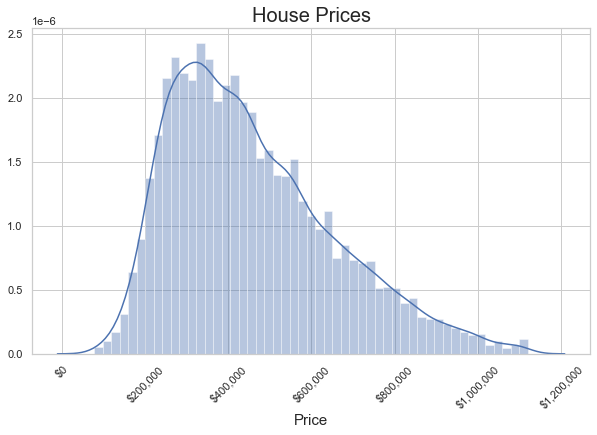

In [91]:
# Setting the figure and plotting
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(model2_df['price'], bins='auto')

# Adjusting the money ticks 
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.xaxis.set_major_formatter(tick_money)
plt.xticks(rotation=45)

# Setting the title and labels
ax.set_xlabel('Price', fontsize=15)
ax.set_title('House Prices', fontsize=20);

> With the outliers removed from price there is a much more normal looking distribution than before.

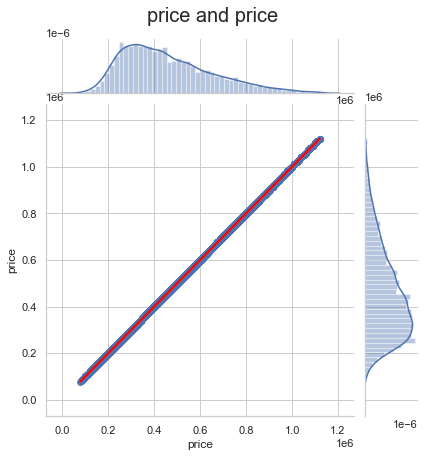

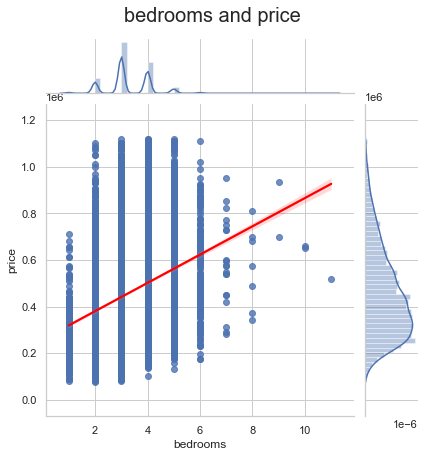

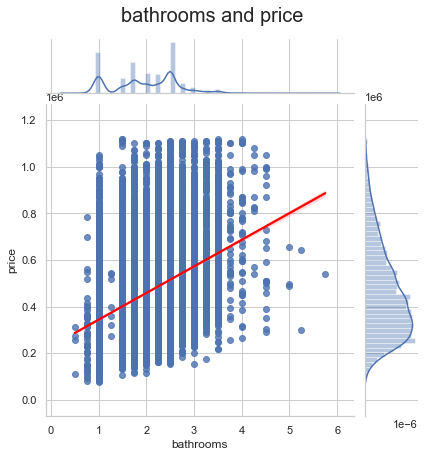

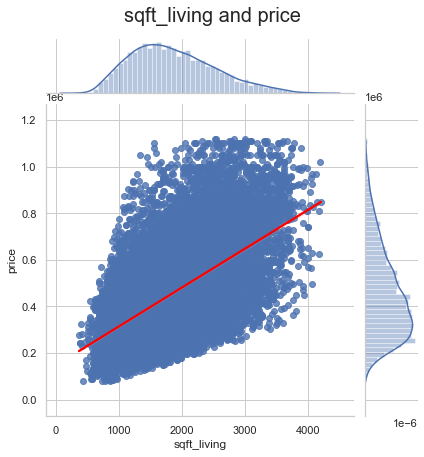

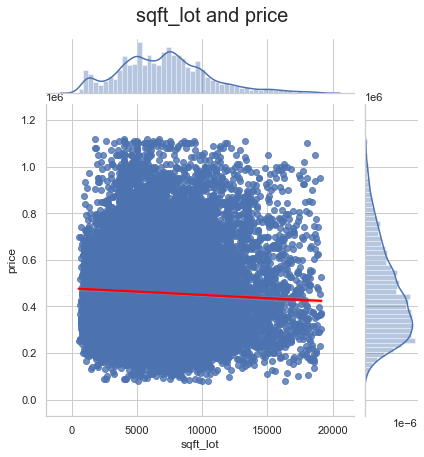

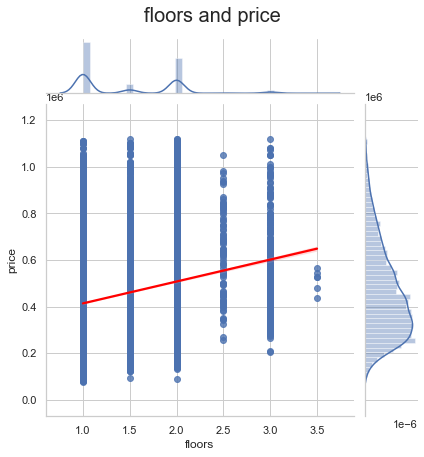

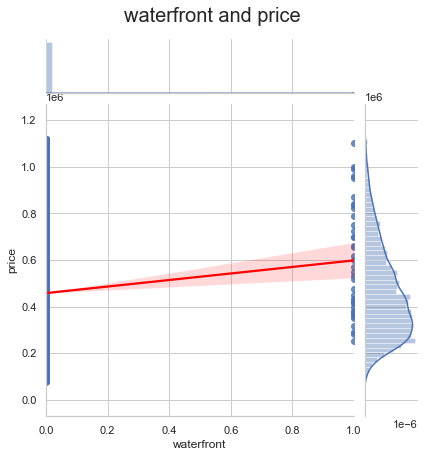

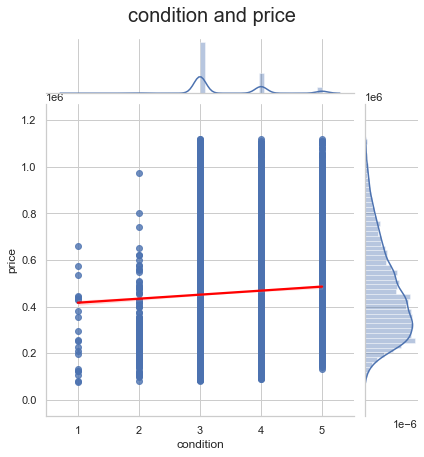

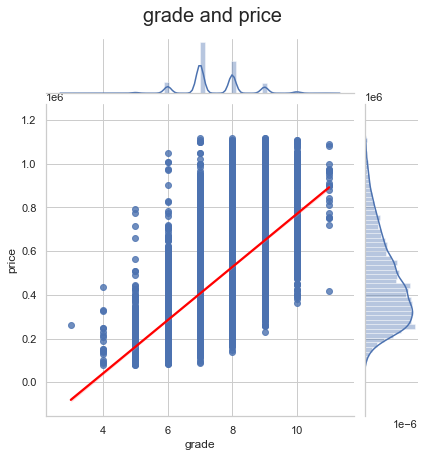

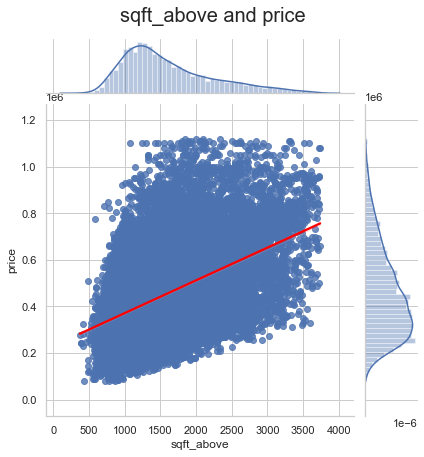

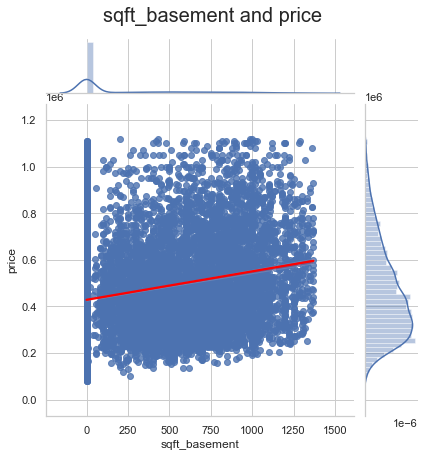

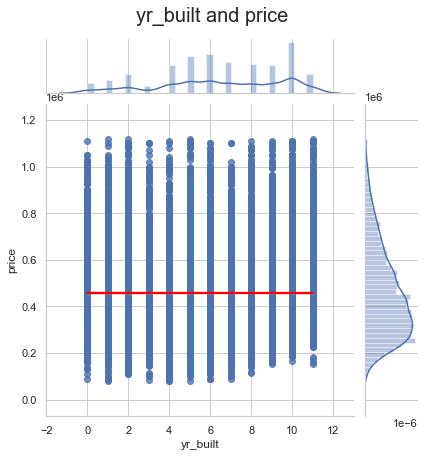

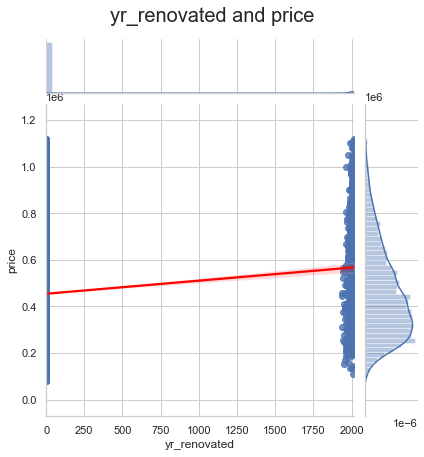

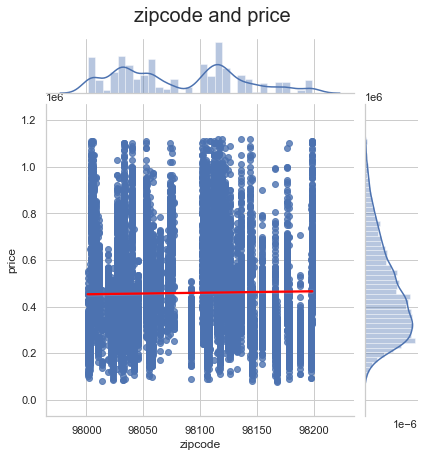

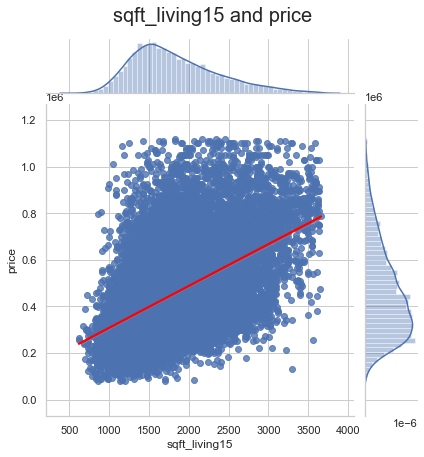

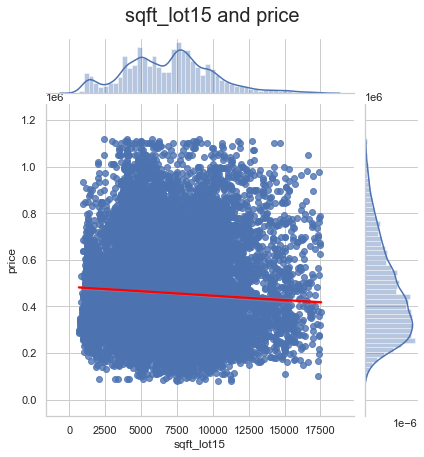

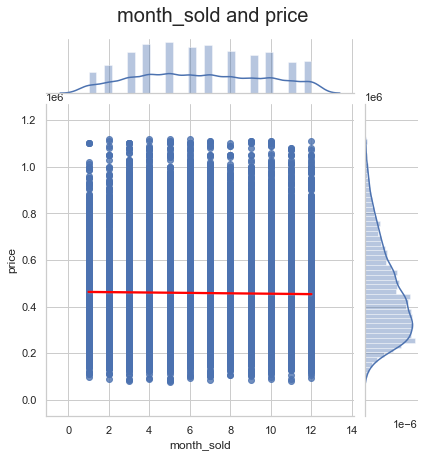

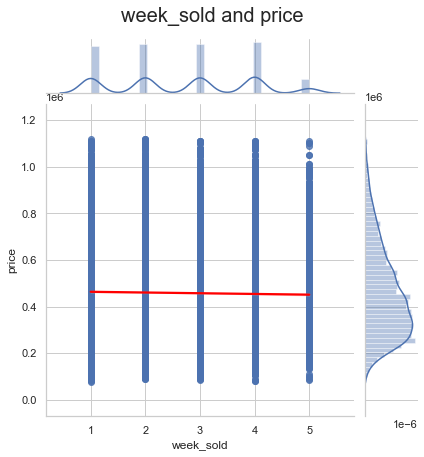

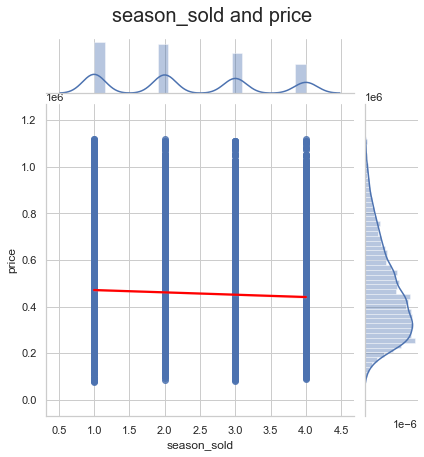

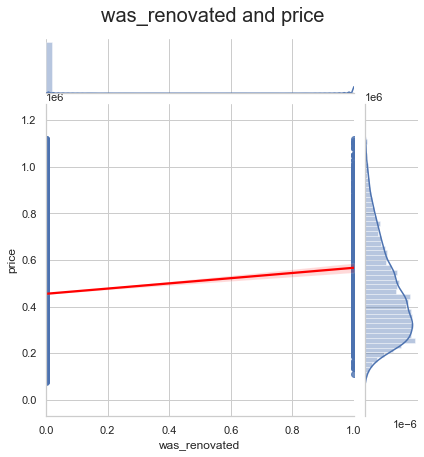

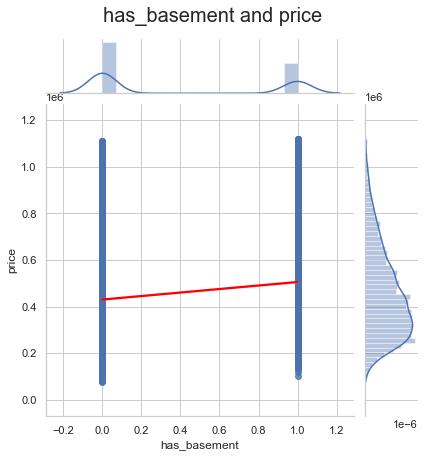

In [92]:
# Looping through the columns to feed each into the function above
cols = list(model2_df.columns)
for col in cols:
    explore_plot(model2_df, col)

> Many of the features are more normally distributed with less dramatic tails. I decided to remove both sqft_lot and sqft_lot15 since there is not a good linear relationship there and they are not very normally distributed. I also decided to remove yr_renovated and sqft_basement as both of those columns are so full of zeros. Instead I will rely on the was_renovated and has_basement columns to account for renovations and basements. I am hoping that removing these will improve my residual normality and homoscedasticity.

In [93]:
model2_df.drop(columns=['sqft_lot', 'sqft_lot15', 'yr_renovated', 
                        'sqft_basement'], inplace=True)

In [94]:
model2_df.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,month_sold,week_sold,season_sold,was_renovated,has_basement
id,,,,,,,,,,,,,,,,,
7129300520,221900,3,1.000,1180,1.000,0,3,7,1180,5,98178,1340,10,2,3,0,0
6414100192,538000,3,2.250,2570,2.000,0,3,7,2170,5,98125,1690,12,2,4,1,1
5631500400,180000,2,1.000,770,1.000,0,3,6,770,3,98028,2720,2,4,4,0,0
2487200875,604000,4,3.000,1960,1.000,0,5,7,1050,6,98136,1360,12,2,4,0,1
1954400510,510000,3,2.000,1680,1.000,0,3,8,1680,8,98074,1800,2,3,4,0,0


## Results

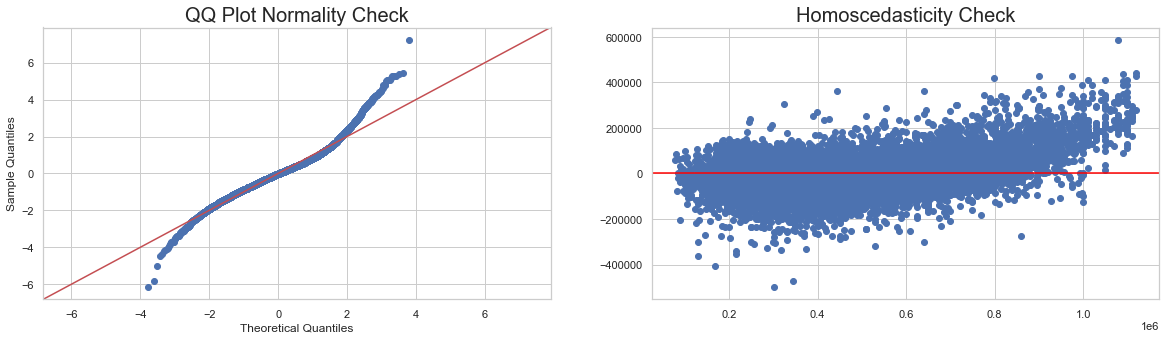

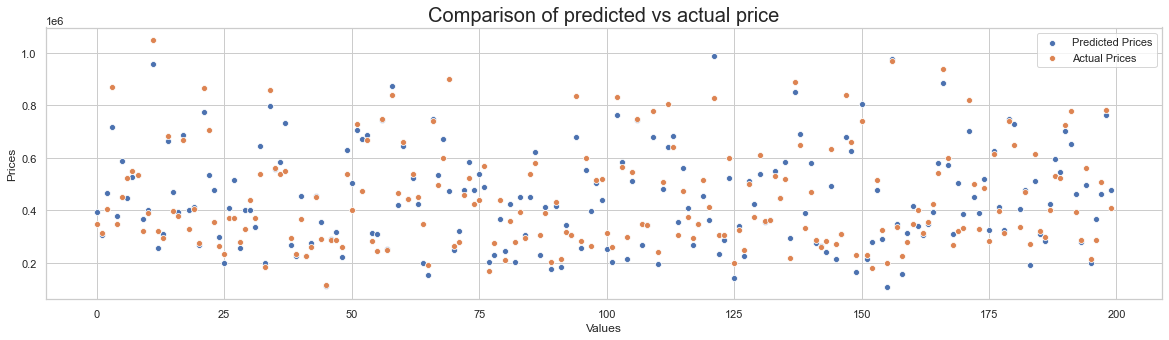

Model test data R2 score: 0.8283512414001497
K-fold cross validation negative MSE: -17657429034.673695


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     593.6
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:47:10   Log-Likelihood:            -1.6791e+05
No. Observations:               13198   AIC:                         3.360e+05
Df Residuals:                   13088   BIC:                         3.369e+05
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -3.36e+05   1.83e+04    -18.394      0.000   -3.72e+05      -3e+05
C(condition)[T.2]    7.137e+04    2.1e+04      3.391      0.001    3.01e+04    1.13e+05
C(condition)[T.3]    9.984e+04   1.94e+04      5.138      0.000    6.17e+04    1.38e+05
C(condition)[T.4]    1.253e+05   1.95e+04      6.443      0.000    8.72e+04    1.63e+05
C(condition)[T.5]     1.54e+05   1.96e+04      7.869      0.000    1.16e+05    1.92e+05
C(yr_built)[T.1]     5926.9386   5324.353      1.113      0.266   -4509.566    1.64e+04
C(yr_built)[T.2]     1.744e+04   4963.175      3.514      0.000    7711.035    2.72e+04
C(yr_built)[T.3]     1.457e+04   6334.946      2.300      0.021    2153.685     2.7e+04
C(yr_built)[T.4]    -6203.2084   4928.735     -1.259      0.208   -1.59e+04    3457.829
C(yr_built)[T.5]    -2.201e+04   4885.065     -4.505      0.000   -3.16e+04   -1.24e+04
C(yr_built)[T.6]    -3.248e+04   5021.787     -6.469      0.000   -4.23e+04   -2.26e+04
C(yr_built)[T.7]    -4.133e+04   5255.306     -7.865      0.000   -5.16e+04    -3.1e+04
C(yr_built)[T.8]     -2.58e+04   5368.386     -4.805      0.000   -3.63e+04   -1.53e+04
C(yr_built)[T.9]    -3.676e+04   5578.897     -6.588      0.000   -4.77e+04   -2.58e+04
C(yr_built)[T.10]   -4.963e+04   5363.710     -9.253      0.000   -6.01e+04   -3.91e+04
C(yr_built)[T.11]   -1.625e+04   5875.876     -2.765      0.006   -2.78e+04   -4729.574
C(zipcode)[T.98002]  6656.6354   8897.966      0.748      0.454   -1.08e+04    2.41e+04
C(zipcode)[T.98003]   640.7884   8213.213      0.078      0.938   -1.55e+04    1.67e+04
C(zipcode)[T.98004]  5.127e+05   9952.371     51.515      0.000    4.93e+05    5.32e+05
C(zipcode)[T.98005]  3.232e+05   1.16e+04     27.918      0.000    3.01e+05    3.46e+05
C(zipcode)[T.98006]  2.676e+05   7833.622     34.161      0.000    2.52e+05    2.83e+05
C(zipcode)[T.98007]  2.515e+05   9995.386     25.160      0.000    2.32e+05    2.71e+05
C(zipcode)[T.98008]   2.46e+05   8454.259     29.098      0.000    2.29e+05    2.63e+05
C(zipcode)[T.98010]   1.06e+05   1.48e+04      7.174      0.000    7.71e+04    1.35e+05
C(zipcode)[T.98011]  1.383e+05   8993.074     15.378      0.000    1.21e+05    1.56e+05
C(zipcode)[T.98014]  9.618e+04   1.57e+04      6.112      0.000    6.53e+04    1.27e+05
C(zipcode)[T.98019]  9.199e+04   9812.369      9.375      0.000    7.28e+04    1.11e+05
C(zipcode)[T.98022]  5732.8097   9816.369      0.584      0.559   -1.35e+04     2.5e+04
C(zipcode)[T.98023]  -1.96e+04   7220.609     -2.715      0.007   -3.38e+04   -5450.316
C(zipcode)[T.98024]  1.533e+05   1.96e+04      7.830      0.000    1.15e+05    1.92e+05
C(zipcode)[T.98027]  2.194e+05   8499.546     25.819      0.000    2.03e+05    2.36e+05
C(zipcode)[T.98028]  1.297e+05   8370.629     15.495      0.000    1.13e+05    1.46e+05
C(z

In [95]:
model2 = make_model(model2_df)

> Insights for this model:
* The r2 score has gone up by over 3% points and the r2 for the test data is much closer to the training data this time. 
* The residuals are greatly improved being more normally distributed and being more homoscedastic. There is still room for improvement on the residuals.
* The scale on the comparison of the actual and predicted prices has gone way down so the two are much closer together. 
* The cross validation score has gone up by a lot.
* Most p-values look significant but I have some wildly large p-values to address.
* Overall, a great step of improvement. Let's see how I can improve it more.

# Model 3

## Removing low p-values

My next step is to address the features with low p-values. Any features that are categorical will be left in the modeling if the majority of the categories have a significant p-value. Likewise, the whole category will be removed if the majority have non-significant p-values.

In [96]:
# Function to identify the insignificant p-values
def bad_pvalues(model, verbose=True):
    
#     Pulling out the p-values and identifying the ones above .05
    pvalues = model.pvalues
    bad_features = pvalues[pvalues > .05]
    
#     Excluding the intercept in case it has a high p-value
    if 'Intercept' in bad_features:
        bad_features.remove('Intercept')
        
#      Printing a statement of the bad p-values
    if verbose:
        print(f'{len(bad_features)} bad p-values to be reviewed:\n' 
              + f'{bad_features}')
    return bad_features

In [97]:
model2_bad_pvals = bad_pvalues(model2)

15 bad p-values to be reviewed:
C(yr_built)[T.1]      0.266
C(yr_built)[T.4]      0.208
C(zipcode)[T.98002]   0.454
C(zipcode)[T.98003]   0.938
C(zipcode)[T.98022]   0.559
C(zipcode)[T.98030]   0.934
C(zipcode)[T.98031]   0.177
C(zipcode)[T.98032]   0.681
C(zipcode)[T.98042]   0.657
C(month_sold)[T.2]    0.054
C(month_sold)[T.12]   0.417
C(week_sold)[T.2]     0.993
C(week_sold)[T.3]     0.286
C(week_sold)[T.4]     0.101
C(week_sold)[T.5]     0.995
dtype: float64


> From this list I am going to remove week sold as none of the categories seem to be very significant. I am going to leave yr_built, month_sold, and zipcode alone as the majority of those categories are significant.

In [98]:
model3_df = model2_df.copy()
model3_df.drop(columns=(['week_sold']), inplace=True)
model3_df.shape

(17598, 16)

## Results

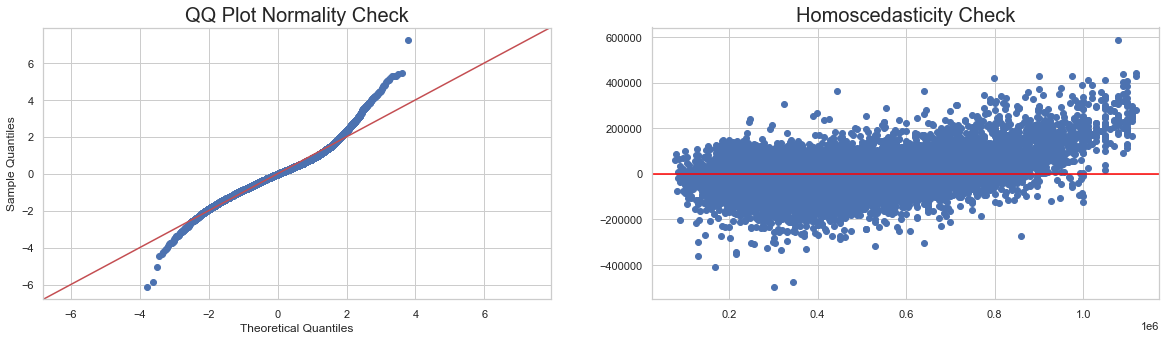

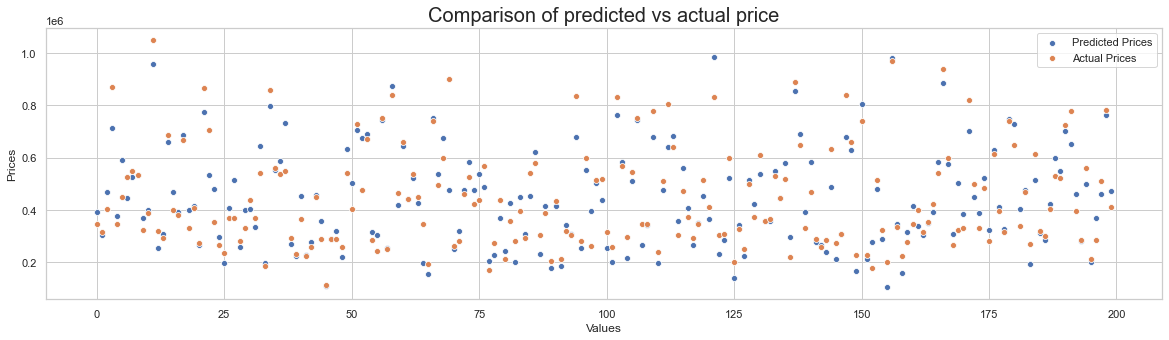

Model test data R2 score: 0.8283344671003985
K-fold cross validation negative MSE: -17661489594.12057


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     616.2
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:47:14   Log-Likelihood:            -1.6791e+05
No. Observations:               13198   AIC:                         3.360e+05
Df Residuals:                   13092   BIC:                         3.368e+05
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3.373e+05   1.82e+04    -18.496      0.000   -3.73e+05   -3.02e+05
C(condition)[T.2]     7.12e+04    2.1e+04      3.384      0.001       3e+04    1.12e+05
C(condition)[T.3]    9.947e+04   1.94e+04      5.119      0.000    6.14e+04    1.38e+05
C(condition)[T.4]     1.25e+05   1.95e+04      6.425      0.000    8.69e+04    1.63e+05
C(condition)[T.5]    1.536e+05   1.96e+04      7.851      0.000    1.15e+05    1.92e+05
C(yr_built)[T.1]     5938.9726   5324.124      1.115      0.265   -4497.084    1.64e+04
C(yr_built)[T.2]     1.758e+04   4962.619      3.543      0.000    7855.886    2.73e+04
C(yr_built)[T.3]     1.463e+04   6333.756      2.309      0.021    2210.616     2.7e+04
C(yr_built)[T.4]    -6153.3155   4928.329     -1.249      0.212   -1.58e+04    3506.924
C(yr_built)[T.5]     -2.19e+04   4884.246     -4.483      0.000   -3.15e+04   -1.23e+04
C(yr_built)[T.6]    -3.229e+04   5020.411     -6.433      0.000   -4.21e+04   -2.25e+04
C(yr_built)[T.7]    -4.122e+04   5254.410     -7.845      0.000   -5.15e+04   -3.09e+04
C(yr_built)[T.8]    -2.559e+04   5366.441     -4.769      0.000   -3.61e+04   -1.51e+04
C(yr_built)[T.9]    -3.662e+04   5578.015     -6.565      0.000   -4.76e+04   -2.57e+04
C(yr_built)[T.10]   -4.936e+04   5361.394     -9.206      0.000   -5.99e+04   -3.88e+04
C(yr_built)[T.11]   -1.603e+04   5874.553     -2.728      0.006   -2.75e+04   -4510.763
C(zipcode)[T.98002]  6826.5782   8895.991      0.767      0.443   -1.06e+04    2.43e+04
C(zipcode)[T.98003]   638.6542   8212.181      0.078      0.938   -1.55e+04    1.67e+04
C(zipcode)[T.98004]  5.131e+05   9949.201     51.569      0.000    4.94e+05    5.33e+05
C(zipcode)[T.98005]  3.233e+05   1.16e+04     27.919      0.000    3.01e+05    3.46e+05
C(zipcode)[T.98006]  2.678e+05   7830.293     34.205      0.000    2.52e+05    2.83e+05
C(zipcode)[T.98007]  2.516e+05   9992.741     25.183      0.000    2.32e+05    2.71e+05
C(zipcode)[T.98008]  2.462e+05   8453.375     29.120      0.000     2.3e+05    2.63e+05
C(zipcode)[T.98010]  1.059e+05   1.48e+04      7.167      0.000     7.7e+04    1.35e+05
C(zipcode)[T.98011]  1.384e+05   8990.731     15.396      0.000    1.21e+05    1.56e+05
C(zipcode)[T.98014]  9.628e+04   1.57e+04      6.119      0.000    6.54e+04    1.27e+05
C(zipcode)[T.98019]  9.239e+04   9810.448      9.417      0.000    7.32e+04    1.12e+05
C(zipcode)[T.98022]  5876.4243   9815.540      0.599      0.549   -1.34e+04    2.51e+04
C(zipcode)[T.98023] -1.956e+04   7219.980     -2.709      0.007   -3.37e+04   -5403.817
C(zipcode)[T.98024]  1.537e+05   1.96e+04      7.851      0.000    1.15e+05    1.92e+05
C(zipcode)[T.98027]  2.197e+05   8498.064     25.849      0.000    2.03e+05    2.36e+05
C(zipcode)[T.98028]  1.299e+05   8369.250     15.521      0.000    1.13e+05    1.46e+05
C(z

In [99]:
model3 = make_model(model3_df)

> Insights for this model:
* I was hoping that my residuals would improve but they look the same as before.
* The r2 is the same as before
* Overall, removing the low p-value features didn't have very much impact on my model.

# Model 4

My approach for this next model iteration is to address multicolinearity and VIF. I followed a guideline of about a 0.75 threshold for multicolinearity and 6 for VIF.

## Multicolinearity

In [100]:
# Creating the dataframe for model iteration 4
model4_df = model3_df.copy()

In [101]:
# Writing a function to create a correlation heat map and chart
def multicol_plot(df):
    
#   Creating a temporary new dataframe
    new_df = df.copy()
    
#   Converting the category types to int so they will show up in the heatmap
    categories = new_df.select_dtypes('category')
    for col in categories:
        new_df[col]= new_df[col].astype('int64')  
        
#   Generating the correlation chart 
    corr = abs(new_df.corr())
    
#   Creating a mask that will eliminate redundant values in the heatmap
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
#   Plotting the figure and applying the mask
    fig = plt.figure()
    fig.set_size_inches(12,12)
    sns.heatmap(corr, annot=True, mask=mask)
    plt.show();
    
    display(corr)
    return corr

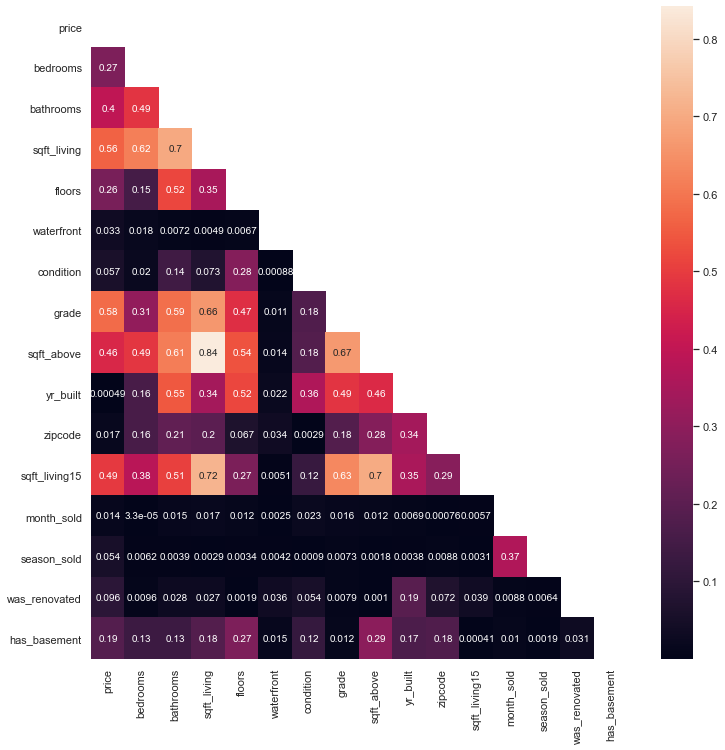

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,month_sold,season_sold,was_renovated,has_basement
price,1.000,0.267,0.397,0.565,0.260,0.033,0.057,0.580,0.456,0.000,0.017,0.494,0.014,0.054,0.096,0.185
bedrooms,0.267,1.000,0.485,0.618,0.154,0.018,0.020,0.306,0.490,0.159,0.161,0.382,0.000,0.006,0.010,0.135
bathrooms,0.397,0.485,1.000,0.698,0.519,0.007,0.144,0.589,0.614,0.549,0.212,0.510,0.015,0.004,0.028,0.134
sqft_living,0.565,0.618,0.698,1.000,0.349,0.005,0.073,0.663,0.842,0.343,0.200,0.721,0.017,0.003,0.027,0.182
floors,0.260,0.154,0.519,0.349,1.000,0.007,0.280,0.472,0.538,0.517,0.067,0.266,0.012,0.003,0.002,0.268
waterfront,0.033,0.018,0.007,0.005,0.007,1.000,0.001,0.011,0.014,0.022,0.034,0.005,0.002,0.004,0.036,0.015
condition,0.057,0.020,0.144,0.073,0.280,0.001,1.000,0.176,0.183,0.364,0.003,0.123,0.023,0.001,0.054,0.122
grade,0.580,0.306,0.589,0.663,0.472,0.011,0.176,1.000,0.667,0.486,0.182,0.632,0.016,0.007,0.008,0.012
sqft_above,0.456,0.490,0.614,0.842,0.538,0.014,0.183,0.667,1.000,0.462,0.282,0.701,0.012,0.002,0.001,0.294
yr_built,0.000,0.159,0.549,0.343,0.517,0.022,0.364,0.486,0.462,1.000,0.344,0.355,0.007,0.004,0.192,0.171


In [102]:
# Running the function
model4_corr = multicol_plot(model4_df)

> Interpretation of the results:
* Squarefoot above and squarefoot living are highly correlated. I am going to keep squarefoot living since the overall squarefootage of a home is a more meaningful metric.
* Squarefoot living and squarefoot living15 are also highly correlated and I think I will go ahead and eliminate squarefoot living15 even though it isn't technically over the threshold. Again, I think that the squarefootage of the home is the more meaningful metric so I will eliminate the other.

In [103]:
# Dropping selected columns
model4_df.drop(columns=['sqft_above', 'sqft_living15'], inplace=True)

## Variance Inflation Factor

In [104]:
# Writing a function to get vif scores for features
def vif_results(df, target='price'):
    
#   Dropping the target and adding a constant
    new_df = df.drop(columns=target, axis=1)
    new_df = sm.add_constant(new_df)
    
#   Turning the category data types to integers so they show up in the VIF
    categories = new_df.select_dtypes('category')
    for col in categories:
        new_df[col]= new_df[col].astype('int64')    

#   Creating an empty list to append to  
    vif_list = []
#   Iterating through the columns of the dataframe
    for x in range(new_df.shape[1]):
        
#       Running the vif for each column and adding it to the empty list
        vif = variance_inflation_factor(new_df.values, x)
        vif_list.append(vif)
        
#   Creating a series for the columns and the vif list
    results = pd.Series(dict(zip(new_df.columns, vif_list)))
    print(results)
    
#   Identifying features that are above the threshold
    threshold = 6
    bad_columns = list(results[results > threshold].index)
    
#   Removing the constant from being included in the bad features
    if 'const' in bad_columns:
        bad_columns.remove('const')
        
    return bad_columns

In [105]:
vif_columns = vif_results(model4_df)
vif_columns

const           4171489.470
bedrooms              1.736
bathrooms             2.968
sqft_living           3.275
floors                1.909
waterfront            1.003
condition             1.230
grade                 2.222
yr_built              2.273
zipcode               1.259
month_sold            1.158
season_sold           1.157
was_renovated         1.097
has_basement          1.342
dtype: float64


[]

> There are no features above the threshold so I am not going to remove any more features.

## Results

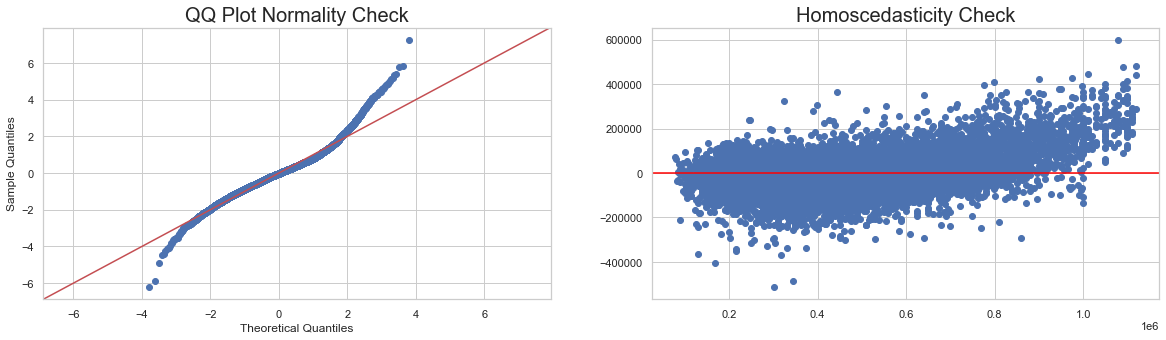

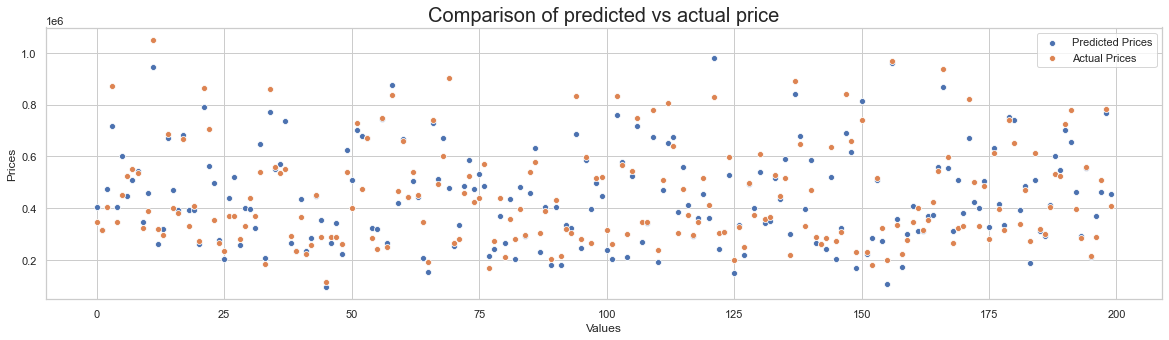

Model test data R2 score: 0.8216745660782332
K-fold cross validation negative MSE: -18051825074.239555


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     602.5
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:47:19   Log-Likelihood:            -1.6814e+05
No. Observations:               13198   AIC:                         3.365e+05
Df Residuals:                   13094   BIC:                         3.373e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3.159e+05   1.85e+04    -17.076      0.000   -3.52e+05    -2.8e+05
C(condition)[T.2]      5.9e+04   2.14e+04      2.758      0.006    1.71e+04    1.01e+05
C(condition)[T.3]    8.604e+04   1.98e+04      4.356      0.000    4.73e+04    1.25e+05
C(condition)[T.4]    1.092e+05   1.98e+04      5.523      0.000    7.04e+04    1.48e+05
C(condition)[T.5]    1.343e+05   1.99e+04      6.756      0.000    9.54e+04    1.73e+05
C(yr_built)[T.1]     4269.4225   5415.946      0.788      0.431   -6346.617    1.49e+04
C(yr_built)[T.2]     1.742e+04   5048.935      3.450      0.001    7520.750    2.73e+04
C(yr_built)[T.3]     1.229e+04   6442.864      1.908      0.056    -337.689    2.49e+04
C(yr_built)[T.4]    -1.032e+04   5010.152     -2.060      0.039   -2.01e+04    -498.852
C(yr_built)[T.5]    -2.967e+04   4955.453     -5.987      0.000   -3.94e+04      -2e+04
C(yr_built)[T.6]    -4.303e+04   5082.086     -8.466      0.000    -5.3e+04   -3.31e+04
C(yr_built)[T.7]    -5.072e+04   5325.241     -9.525      0.000   -6.12e+04   -4.03e+04
C(yr_built)[T.8]     -3.42e+04   5444.573     -6.281      0.000   -4.49e+04   -2.35e+04
C(yr_built)[T.9]     -4.17e+04   5669.865     -7.355      0.000   -5.28e+04   -3.06e+04
C(yr_built)[T.10]   -5.249e+04   5452.390     -9.627      0.000   -6.32e+04   -4.18e+04
C(yr_built)[T.11]    -1.92e+04   5974.862     -3.213      0.001   -3.09e+04   -7484.506
C(zipcode)[T.98002]   213.9277   9039.912      0.024      0.981   -1.75e+04    1.79e+04
C(zipcode)[T.98003]  1279.1273   8354.997      0.153      0.878   -1.51e+04    1.77e+04
C(zipcode)[T.98004]  5.292e+05   1.01e+04     52.491      0.000    5.09e+05    5.49e+05
C(zipcode)[T.98005]  3.335e+05   1.18e+04     28.342      0.000     3.1e+05    3.57e+05
C(zipcode)[T.98006]  2.785e+05   7941.798     35.068      0.000    2.63e+05    2.94e+05
C(zipcode)[T.98007]  2.559e+05   1.02e+04     25.179      0.000    2.36e+05    2.76e+05
C(zipcode)[T.98008]  2.501e+05   8598.027     29.084      0.000    2.33e+05    2.67e+05
C(zipcode)[T.98010]   1.04e+05    1.5e+04      6.914      0.000    7.45e+04    1.33e+05
C(zipcode)[T.98011]  1.465e+05   9136.185     16.034      0.000    1.29e+05    1.64e+05
C(zipcode)[T.98014]  8.741e+04    1.6e+04      5.464      0.000    5.61e+04    1.19e+05
C(zipcode)[T.98019]  9.906e+04   9975.352      9.930      0.000    7.95e+04    1.19e+05
C(zipcode)[T.98022]  3409.1968   9983.964      0.341      0.733   -1.62e+04     2.3e+04
C(zipcode)[T.98023] -1.663e+04   7344.273     -2.264      0.024    -3.1e+04   -2235.061
C(zipcode)[T.98024]  1.454e+05   1.99e+04      7.302      0.000    1.06e+05    1.84e+05
C(zipcode)[T.98027]   2.25e+05   8641.796     26.036      0.000    2.08e+05    2.42e+05
C(zipcode)[T.98028]  1.338e+05   8507.686     15.731      0.000    1.17e+05    1.51e+05
C(z

In [106]:
model4 = make_model(model4_df)

> Insights for this model:
* The the graphs for the residuals look the same and have not improved.
* The r2 score and cross validation score actually got a little bit worse.

# Model 5

## Log transforming price

My next tactic is going to be to log transform the price column to try to achieve better normality and homoscedasticity with my residuals.

In [107]:
# Creating a new dataframe for this model iteration
model5_df = model4_df.copy()

In [108]:
# Log transforming the price column
model5_df['price'] = model5_df['price'].map(lambda x: np.log(x))

## Checking linearity and normality after log transforming price

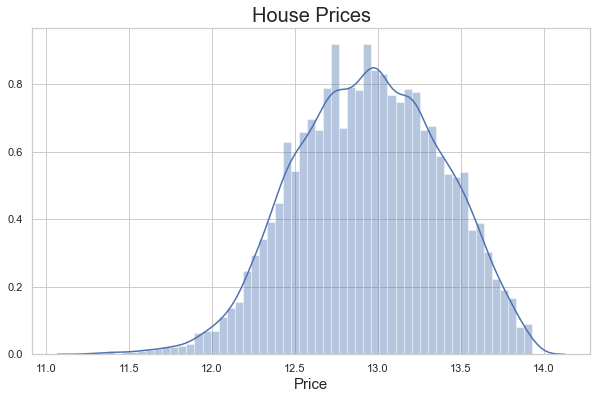

In [109]:
# Setting the figure and plotting
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(model5_df['price'], bins='auto')

# Setting the title and labels
ax.set_xlabel('Price', fontsize=15)
ax.set_title('House Prices', fontsize=20);

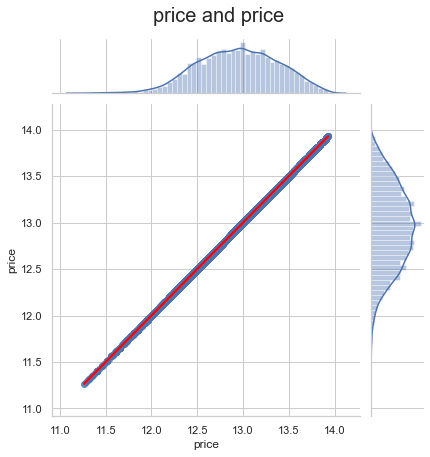

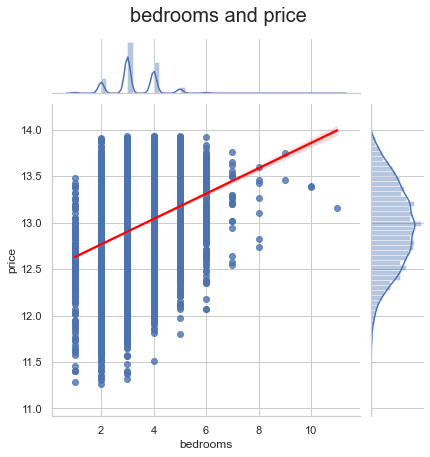

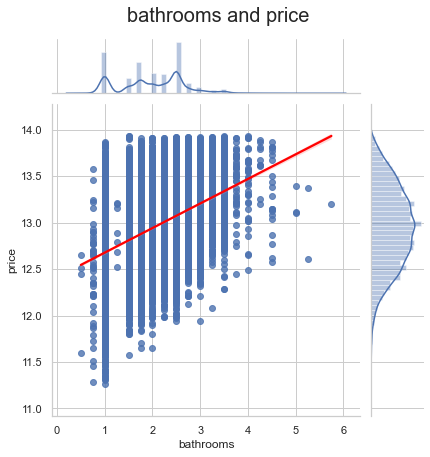

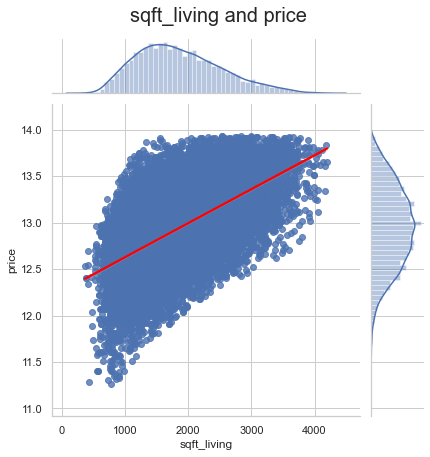

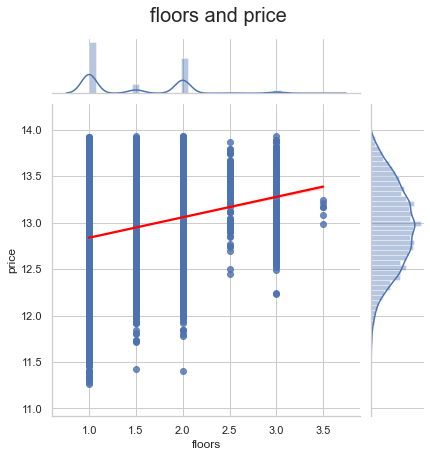

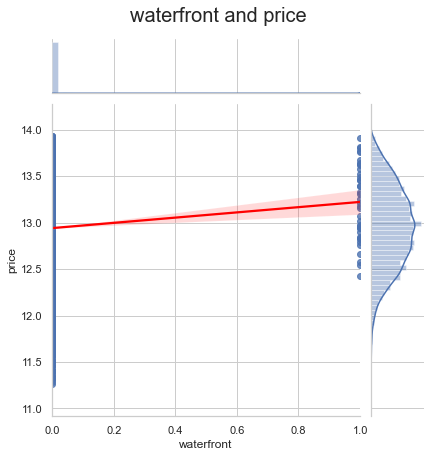

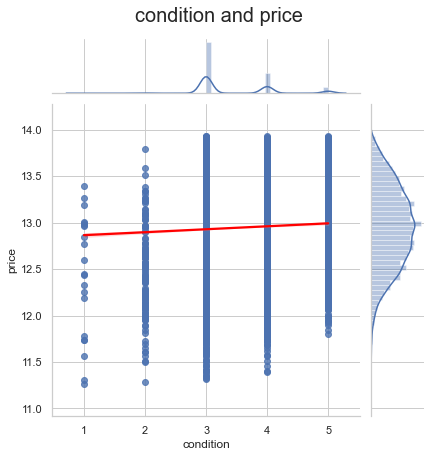

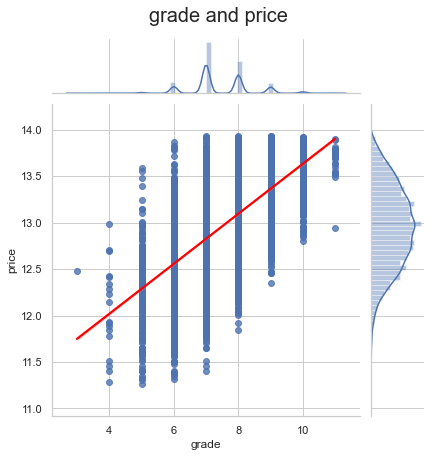

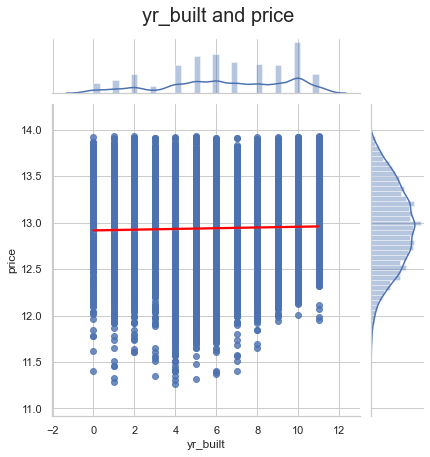

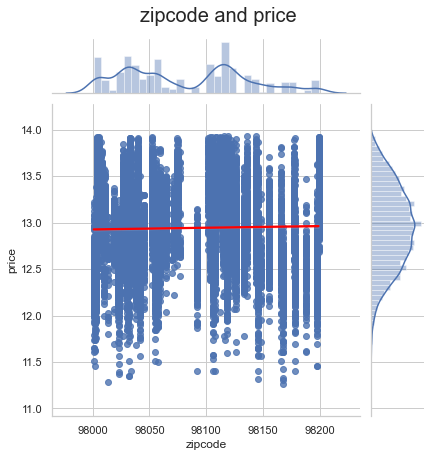

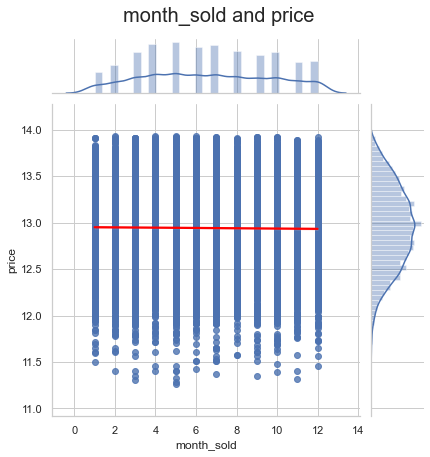

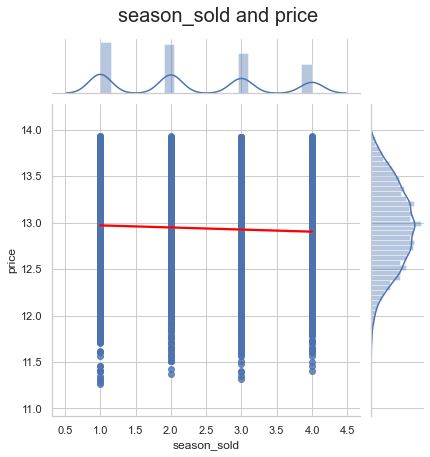

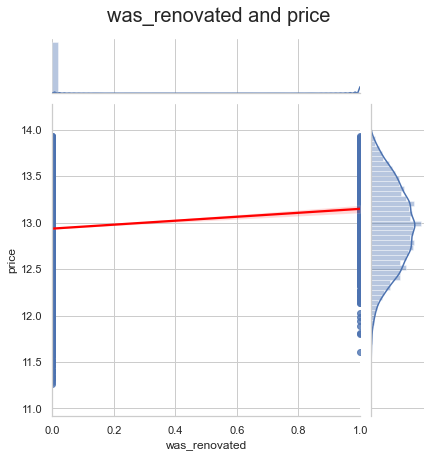

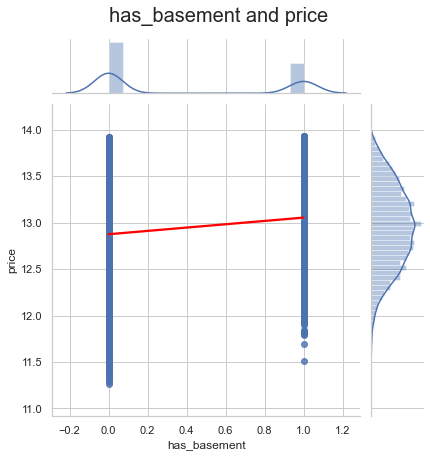

In [110]:
# Checking the distributions and linearity for my features again
cols = list(model5_df.columns)
for col in cols:
    explore_plot(model5_df, col)

## Results

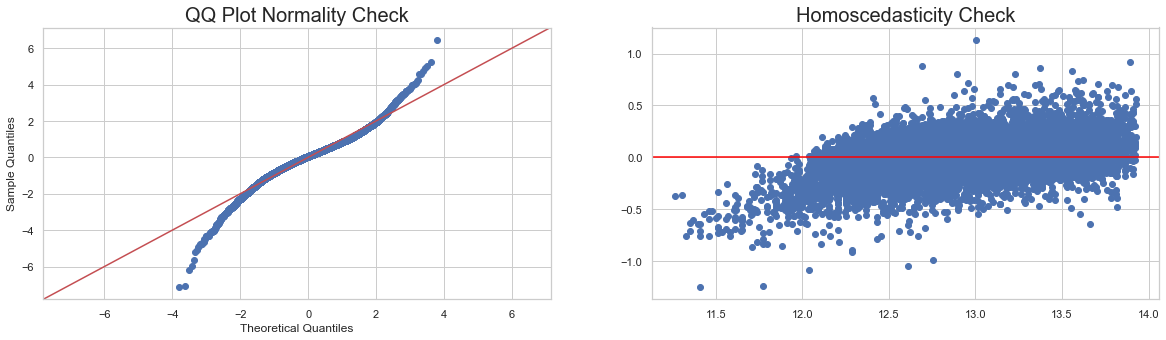

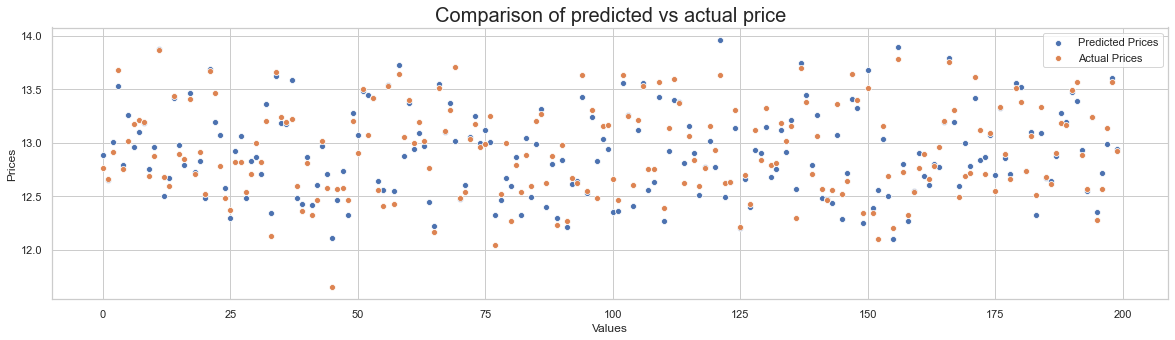

Model test data R2 score: 0.8411617877110329
K-fold cross validation negative MSE: -0.09151899625233245


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     667.2
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:47:46   Log-Likelihood:                 4257.2
No. Observations:               13198   AIC:                            -8306.
Df Residuals:                   13094   BIC:                            -7528.
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.2065      0.039    234.314      0.000       9.129       9.284
C(condition)[T.2]       0.2204      0.045      4.850      0.000       0.131       0.309
C(condition)[T.3]       0.3707      0.042      8.834      0.000       0.288       0.453
C(condition)[T.4]       0.4268      0.042     10.162      0.000       0.344       0.509
C(condition)[T.5]       0.4692      0.042     11.109      0.000       0.386       0.552
C(yr_built)[T.1]       -0.0067      0.012     -0.583      0.560      -0.029       0.016
C(yr_built)[T.2]        0.0204      0.011      1.907      0.057      -0.001       0.041
C(yr_built)[T.3]       -0.0012      0.014     -0.090      0.928      -0.028       0.026
C(yr_built)[T.4]       -0.0469      0.011     -4.411      0.000      -0.068      -0.026
C(yr_built)[T.5]       -0.0690      0.011     -6.555      0.000      -0.090      -0.048
C(yr_built)[T.6]       -0.0985      0.011     -9.120      0.000      -0.120      -0.077
C(yr_built)[T.7]       -0.1021      0.011     -9.028      0.000      -0.124      -0.080
C(yr_built)[T.8]       -0.0581      0.012     -5.023      0.000      -0.081      -0.035
C(yr_built)[T.9]       -0.0572      0.012     -4.747      0.000      -0.081      -0.034
C(yr_built)[T.10]      -0.0804      0.012     -6.943      0.000      -0.103      -0.058
C(yr_built)[T.11]      -0.0169      0.013     -1.328      0.184      -0.042       0.008
C(zipcode)[T.98002]    -0.0362      0.019     -1.886      0.059      -0.074       0.001
C(zipcode)[T.98003]     0.0291      0.018      1.640      0.101      -0.006       0.064
C(zipcode)[T.98004]     1.0995      0.021     51.342      0.000       1.058       1.141
C(zipcode)[T.98005]     0.7952      0.025     31.811      0.000       0.746       0.844
C(zipcode)[T.98006]     0.6703      0.017     39.734      0.000       0.637       0.703
C(zipcode)[T.98007]     0.6727      0.022     31.162      0.000       0.630       0.715
C(zipcode)[T.98008]     0.6823      0.018     37.361      0.000       0.647       0.718
C(zipcode)[T.98010]     0.2426      0.032      7.595      0.000       0.180       0.305
C(zipcode)[T.98011]     0.4717      0.019     24.303      0.000       0.434       0.510
C(zipcode)[T.98014]     0.2197      0.034      6.463      0.000       0.153       0.286
C(zipcode)[T.98019]     0.3438      0.021     16.223      0.000       0.302       0.385
C(zipcode)[T.98022]     0.0153      0.021      0.723      0.470      -0.026       0.057
C(zipcode)[T.98023]    -0.0160      0.016     -1.025      0.305      -0.047       0.015
C(zipcode)[T.98024]     0.4257      0.042     10.062      0.000       0.343       0.509
C(zipcode)[T.98027]     0.5900      0.018     32.138      0.000       0.554       0.626
C(zipcode)[T.98028]     0.4318      0.018     23.896      0.000       0.396       0.467
C(z

In [111]:
model5 = make_model(model5_df)

> Insights for this model:
* The residuals for the qq plot have maybe improved a little bit.
* It's hard to judge if homoscedasticity has improved as the scale has also changed but there is still a little bit of a cone shape.
* It is hard to tell if the comparison of the predicted and actual prices improved because the scale changed.
* The r2 score went up a little which is good improvement.
* The cross validation score greatly improved and is a much higher number than before.

# Model 6

## Checking p-values

In [112]:
# Checking for high p-values from this model
model5_bad_pvals = bad_pvalues(model5)

12 bad p-values to be reviewed:
C(yr_built)[T.1]      0.560
C(yr_built)[T.2]      0.057
C(yr_built)[T.3]      0.928
C(yr_built)[T.11]     0.184
C(zipcode)[T.98002]   0.059
C(zipcode)[T.98003]   0.101
C(zipcode)[T.98022]   0.470
C(zipcode)[T.98023]   0.305
C(zipcode)[T.98032]   0.362
C(zipcode)[T.98092]   0.826
C(month_sold)[T.12]   0.787
bedrooms              0.962
dtype: float64


> Bedrooms now has an insignificant p value after log transforming price and will need to be removed.

In [113]:
# Removing the bedrooms column from my next dataframe iteration
model6_df = model5_df.copy()
model6_df.drop(columns=['bedrooms'], inplace=True)

## Multicolinearity

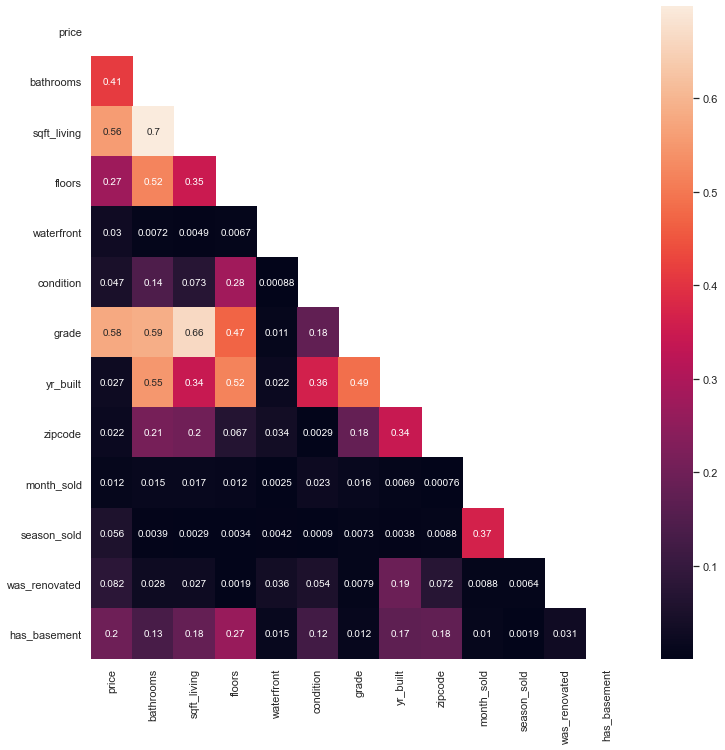

,price,bathrooms,sqft_living,floors,waterfront,condition,grade,yr_built,zipcode,month_sold,season_sold,was_renovated,has_basement
price,1.000,0.415,0.559,0.275,0.030,0.047,0.581,0.027,0.022,0.012,0.056,0.082,0.199
bathrooms,0.415,1.000,0.698,0.519,0.007,0.144,0.589,0.549,0.212,0.015,0.004,0.028,0.134
sqft_living,0.559,0.698,1.000,0.349,0.005,0.073,0.663,0.343,0.200,0.017,0.003,0.027,0.182
floors,0.275,0.519,0.349,1.000,0.007,0.280,0.472,0.517,0.067,0.012,0.003,0.002,0.268
waterfront,0.030,0.007,0.005,0.007,1.000,0.001,0.011,0.022,0.034,0.002,0.004,0.036,0.015
condition,0.047,0.144,0.073,0.280,0.001,1.000,0.176,0.364,0.003,0.023,0.001,0.054,0.122
grade,0.581,0.589,0.663,0.472,0.011,0.176,1.000,0.486,0.182,0.016,0.007,0.008,0.012
yr_built,0.027,0.549,0.343,0.517,0.022,0.364,0.486,1.000,0.344,0.007,0.004,0.192,0.171
zipcode,0.022,0.212,0.200,0.067,0.034,0.003,0.182,0.344,1.000,0.001,0.009,0.072,0.175
month_sold,0.012,0.015,0.017,0.012,0.002,0.023,0.016,0.007,0.001,1.000,0.367,0.009,0.010


In [114]:
# Checking if columns need to be addressed for multicolinearity again
model6_corr = multicol_plot(model6_df)

> Nothing is above .75 so there is nothing to remove here.

## VIF

In [115]:
vif_columns = vif_results(model6_df)
vif_columns

const           4160257.355
bathrooms             2.878
sqft_living           2.595
floors                1.902
waterfront            1.002
condition             1.229
grade                 2.167
yr_built              2.262
zipcode               1.256
month_sold            1.158
season_sold           1.157
was_renovated         1.096
has_basement          1.340
dtype: float64


[]

> No high VIF columns either.

## Results

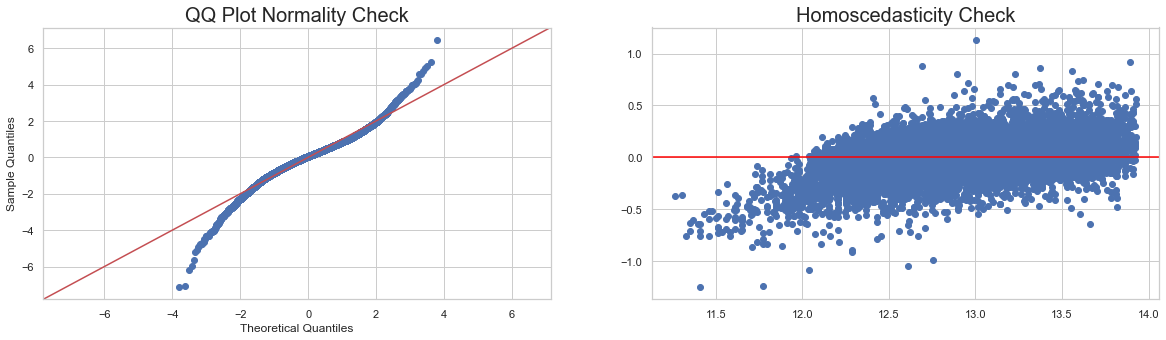

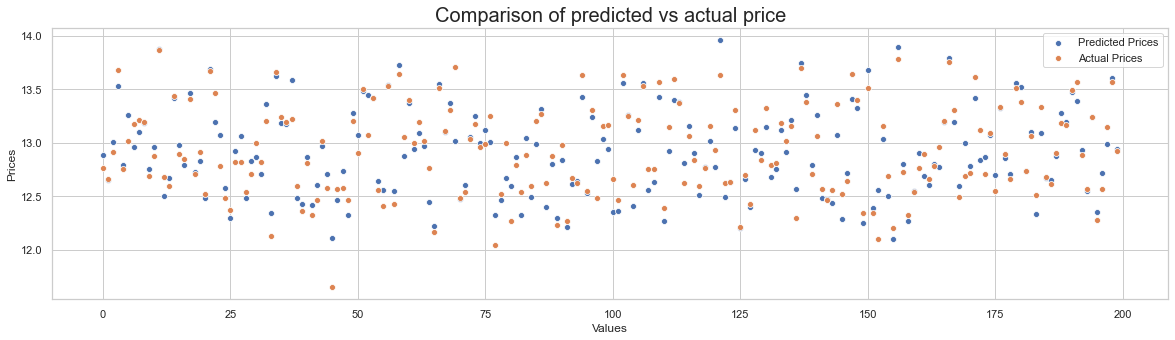

Model test data R2 score: 0.8411684470999987
K-fold cross validation negative MSE: -0.09206813576408432


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     673.8
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:47:51   Log-Likelihood:                 4257.2
No. Observations:               13198   AIC:                            -8308.
Df Residuals:                   13095   BIC:                            -7537.
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.2067      0.039    236.000      0.000       9.130       9.283
C(condition)[T.2]       0.2204      0.045      4.851      0.000       0.131       0.310
C(condition)[T.3]       0.3707      0.042      8.836      0.000       0.288       0.453
C(condition)[T.4]       0.4268      0.042     10.163      0.000       0.344       0.509
C(condition)[T.5]       0.4692      0.042     11.110      0.000       0.386       0.552
C(yr_built)[T.1]       -0.0067      0.012     -0.583      0.560      -0.029       0.016
C(yr_built)[T.2]        0.0204      0.011      1.906      0.057      -0.001       0.041
C(yr_built)[T.3]       -0.0012      0.014     -0.091      0.928      -0.028       0.026
C(yr_built)[T.4]       -0.0470      0.011     -4.413      0.000      -0.068      -0.026
C(yr_built)[T.5]       -0.0690      0.011     -6.556      0.000      -0.090      -0.048
C(yr_built)[T.6]       -0.0984      0.011     -9.129      0.000      -0.120      -0.077
C(yr_built)[T.7]       -0.1021      0.011     -9.029      0.000      -0.124      -0.080
C(yr_built)[T.8]       -0.0581      0.012     -5.032      0.000      -0.081      -0.035
C(yr_built)[T.9]       -0.0572      0.012     -4.759      0.000      -0.081      -0.034
C(yr_built)[T.10]      -0.0805      0.012     -6.972      0.000      -0.103      -0.058
C(yr_built)[T.11]      -0.0169      0.013     -1.333      0.183      -0.042       0.008
C(zipcode)[T.98002]    -0.0362      0.019     -1.886      0.059      -0.074       0.001
C(zipcode)[T.98003]     0.0291      0.018      1.640      0.101      -0.006       0.064
C(zipcode)[T.98004]     1.0995      0.021     51.349      0.000       1.058       1.141
C(zipcode)[T.98005]     0.7952      0.025     31.825      0.000       0.746       0.844
C(zipcode)[T.98006]     0.6703      0.017     39.740      0.000       0.637       0.703
C(zipcode)[T.98007]     0.6728      0.022     31.169      0.000       0.630       0.715
C(zipcode)[T.98008]     0.6823      0.018     37.362      0.000       0.647       0.718
C(zipcode)[T.98010]     0.2426      0.032      7.595      0.000       0.180       0.305
C(zipcode)[T.98011]     0.4716      0.019     24.309      0.000       0.434       0.510
C(zipcode)[T.98014]     0.2196      0.034      6.463      0.000       0.153       0.286
C(zipcode)[T.98019]     0.3437      0.021     16.225      0.000       0.302       0.385
C(zipcode)[T.98022]     0.0153      0.021      0.723      0.470      -0.026       0.057
C(zipcode)[T.98023]    -0.0160      0.016     -1.026      0.305      -0.047       0.015
C(zipcode)[T.98024]     0.4257      0.042     10.062      0.000       0.343       0.509
C(zipcode)[T.98027]     0.5899      0.018     32.146      0.000       0.554       0.626
C(zipcode)[T.98028]     0.4318      0.018     23.900      0.000       0.396       0.467
C(z

In [116]:
model6 = make_model(model6_df)

## p-value check

In [117]:
# Checking p-values
model6_bad_pvals = bad_pvalues(model6)

11 bad p-values to be reviewed:
C(yr_built)[T.1]      0.560
C(yr_built)[T.2]      0.057
C(yr_built)[T.3]      0.928
C(yr_built)[T.11]     0.183
C(zipcode)[T.98002]   0.059
C(zipcode)[T.98003]   0.101
C(zipcode)[T.98022]   0.470
C(zipcode)[T.98023]   0.305
C(zipcode)[T.98032]   0.362
C(zipcode)[T.98092]   0.825
C(month_sold)[T.12]   0.787
dtype: float64


> There are no features to removed based on p-values as these are all categories where the majority of the categories are significant.

> **I am going to use this model iteration for my final model as I have done all I can to improve the model and the residuals while still keeping interpretability.**

# Model 7

# EDA Question 3: Would the residuals improve from log transforming all the non categorical columns?

Since I am having such a hard time seeing improvement in the residuals for this project, I want to see what would the improvement look like if I log transformed all of the non categorical columns. Once all the columns are log transformed then it becomes even less intuitive to interpret, but I want to see what the model will look like.

In [118]:
# Making a copy of the dataframe for this iteration
model7_df = model6_df.copy()

In [119]:
# Grabbing the columns appropriate to transform
num_cols = ['bathrooms', 'sqft_living', 'floors', 'grade']

# Iterating through the number columns and log transforming them
for col in num_cols:
    model7_df[col] = model7_df[col].map(lambda x: np.log(x))

In [120]:
# Checking that the columns were indeed log transformed
model7_df.describe()

,price,bathrooms,sqft_living,floors,waterfront,grade,was_renovated,has_basement
count,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000
mean,12.942,0.628,7.462,0.324,0.002,1.997,0.029,0.372
std,0.435,0.378,0.371,0.353,0.046,0.126,0.168,0.483
min,11.264,-0.693,5.914,0.000,0.000,1.099,0.000,0.000
25%,12.628,0.405,7.215,0.000,0.000,1.946,0.000,0.000
50%,12.948,0.693,7.484,0.000,0.000,1.946,0.000,0.000
75%,13.262,0.916,7.736,0.693,0.000,2.079,0.000,1.000
max,13.929,1.749,8.343,1.253,1.000,2.398,1.000,1.000


## Results

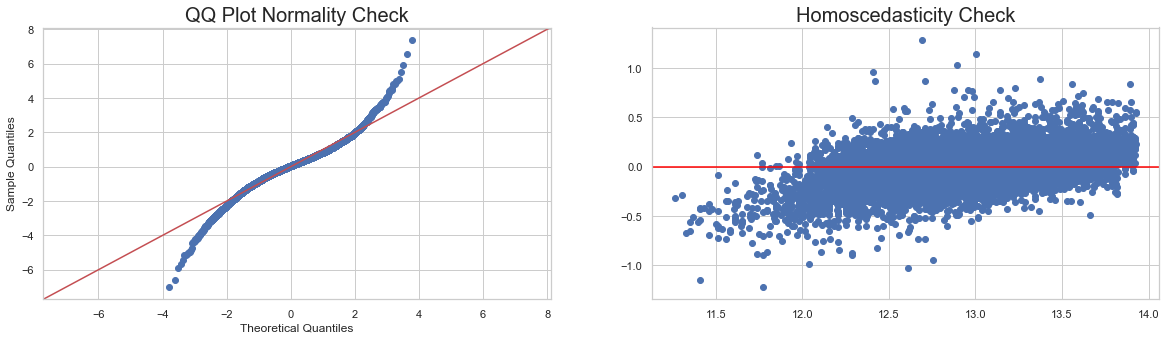

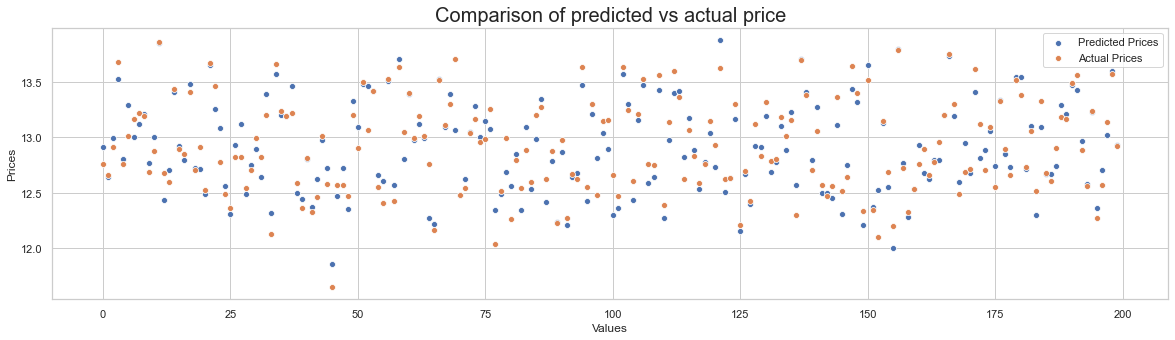

Model test data R2 score: 0.8423536220271876
K-fold cross validation negative MSE: -0.09308613332761213


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     680.0
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:47:54   Log-Likelihood:                 4308.4
No. Observations:               13198   AIC:                            -8411.
Df Residuals:                   13095   BIC:                            -7640.
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.8869      0.055    107.358      0.000       5.779       5.994
C(condition)[T.2]       0.1875      0.045      4.142      0.000       0.099       0.276
C(condition)[T.3]       0.3138      0.042      7.505      0.000       0.232       0.396
C(condition)[T.4]       0.3666      0.042      8.762      0.000       0.285       0.449
C(condition)[T.5]       0.4070      0.042      9.670      0.000       0.324       0.489
C(yr_built)[T.1]       -0.0003      0.011     -0.030      0.976      -0.023       0.022
C(yr_built)[T.2]        0.0243      0.011      2.271      0.023       0.003       0.045
C(yr_built)[T.3]        0.0126      0.014      0.925      0.355      -0.014       0.039
C(yr_built)[T.4]       -0.0357      0.011     -3.365      0.001      -0.057      -0.015
C(yr_built)[T.5]       -0.0854      0.011     -8.119      0.000      -0.106      -0.065
C(yr_built)[T.6]       -0.1210      0.011    -11.211      0.000      -0.142      -0.100
C(yr_built)[T.7]       -0.1221      0.011    -10.800      0.000      -0.144      -0.100
C(yr_built)[T.8]       -0.0757      0.012     -6.570      0.000      -0.098      -0.053
C(yr_built)[T.9]       -0.0673      0.012     -5.627      0.000      -0.091      -0.044
C(yr_built)[T.10]      -0.0784      0.011     -6.850      0.000      -0.101      -0.056
C(yr_built)[T.11]      -0.0129      0.013     -1.024      0.306      -0.037       0.012
C(zipcode)[T.98002]    -0.0245      0.019     -1.283      0.199      -0.062       0.013
C(zipcode)[T.98003]     0.0360      0.018      2.039      0.041       0.001       0.071
C(zipcode)[T.98004]     1.1065      0.021     51.893      0.000       1.065       1.148
C(zipcode)[T.98005]     0.8130      0.025     32.668      0.000       0.764       0.862
C(zipcode)[T.98006]     0.6999      0.017     41.688      0.000       0.667       0.733
C(zipcode)[T.98007]     0.6871      0.021     31.964      0.000       0.645       0.729
C(zipcode)[T.98008]     0.6919      0.018     38.025      0.000       0.656       0.728
C(zipcode)[T.98010]     0.2705      0.032      8.500      0.000       0.208       0.333
C(zipcode)[T.98011]     0.4820      0.019     24.942      0.000       0.444       0.520
C(zipcode)[T.98014]     0.2332      0.034      6.888      0.000       0.167       0.300
C(zipcode)[T.98019]     0.3496      0.021     16.565      0.000       0.308       0.391
C(zipcode)[T.98022]     0.0148      0.021      0.701      0.483      -0.027       0.056
C(zipcode)[T.98023]     0.0002      0.016      0.013      0.990      -0.030       0.031
C(zipcode)[T.98024]     0.4509      0.042     10.699      0.000       0.368       0.534
C(zipcode)[T.98027]     0.6147      0.018     33.630      0.000       0.579       0.651
C(zipcode)[T.98028]     0.4383      0.018     24.353      0.000       0.403       0.474
C(z

In [121]:
model7 = make_model(model7_df)

> Insights from this model:
* I am surprised that the model residuals did not improve. The qq plot actually got a little worse. 
* I am also surprised that there was not a change in the r2 score or the cross validation score.
* Overall the model quality is pretty much the same as the previous model but with a lot less interpretability.


In [122]:
# Checking for insignificant p-values
model7_bad_pvals = bad_pvalues(model7)

9 bad p-values to be reviewed:
C(yr_built)[T.1]      0.976
C(yr_built)[T.3]      0.355
C(yr_built)[T.11]     0.306
C(zipcode)[T.98002]   0.199
C(zipcode)[T.98022]   0.483
C(zipcode)[T.98023]   0.990
C(zipcode)[T.98032]   0.986
C(zipcode)[T.98092]   0.746
C(month_sold)[T.12]   0.562
dtype: float64


> There are more insignificant p-values in this model than in model 6 but still nothing that would justify removing a category. Again, I am surprised that there isn't a more dramatic difference. 

# Interpretation

## Modeling summary

The model I am using to make inferences for sellers is model iteration 4. This model is highly interpretable even though the residuals do not meet a desired normality or homoscedasticity. Model iteration 6 or 7 are technically more accurate models, but considering my audience and goal it will be easier to understand the results from model 4. 

I attempted many efforts to try to improve the residuals and overall model quality including:
* Various outlier removal methods including z-scores, cook's distance, and interquartile range. The interquartile range method was the one shown in this notebook since it produced the best model results.
* Dropping columns with insignificant p-values.
* Dropping features with weak linearity or that were too full of zero values.
* Switching features to categorical where it made sense.
* Dropping features that were too high in multicolinearity or had high VIF scores.
* Log transforming price and log transforming my features as well.

My model 7 has an R-squared value of .841 which means that my model explains 84% of what goes into the sell price for a house. The other 16% could be due to other features that were not included in the dataset, modeling error, or even a certain amount of randomness. The features included in my final model as having a significant impact on the sell price of a house are condition, decade built, zipcode, month sold, season sold, bathrooms, squarefoot living space, floors, if a property is waterfront, grade, if a house was renovated, and if a house has a basement.

## Seller insights

Using my coefficients from model iteration 4 and by graphing some of the features, I am going to make recommendations for home sellers. An important point to take note of is that my model had outliers removed so the model can only be used to make predictions on houses that fall within the range of the data that was used. Looking at the dataset after outlier removal, my model can only be used for houses that would be priced between $ \$78,000 $ and $ \$1,120,000 $. In the .describe() chart below, my data also only had houses with between 1 and 11 bedrooms, a maximum of almost 6 full bathrooms, a maximum of 3.5 floors, and between 370 and 4,200 square feet of living space.

In [123]:
# Looking at the data after outlier removal
model4_df.describe()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,grade,was_renovated,has_basement
count,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000,17598.000
mean,457933.044,3.285,2.001,1860.038,1.474,0.002,7.428,0.029,0.372
std,196710.468,0.866,0.683,663.799,0.544,0.046,0.939,0.168,0.483
min,78000.000,1.000,0.500,370.000,1.000,0.000,3.000,0.000,0.000
25%,305000.000,3.000,1.500,1360.000,1.000,0.000,7.000,0.000,0.000
50%,420000.000,3.000,2.000,1780.000,1.000,0.000,7.000,0.000,0.000
75%,575000.000,4.000,2.500,2290.000,2.000,0.000,8.000,0.000,1.000
max,1120000.000,11.000,5.750,4200.000,3.500,1.000,11.000,1.000,1.000


In [124]:
# Pulling out model coefficients
coeffs = model4.params
coeffs

Intercept             -315861.397
C(condition)[T.2]       58995.869
C(condition)[T.3]       86038.207
C(condition)[T.4]      109190.862
C(condition)[T.5]      134338.732
C(yr_built)[T.1]         4269.423
C(yr_built)[T.2]        17417.396
C(yr_built)[T.3]        12291.260
C(yr_built)[T.4]       -10319.477
C(yr_built)[T.5]       -29667.969
C(yr_built)[T.6]       -43027.313
C(yr_built)[T.7]       -50724.924
C(yr_built)[T.8]       -34196.834
C(yr_built)[T.9]       -41703.381
C(yr_built)[T.10]      -52489.130
C(yr_built)[T.11]      -19196.104
C(zipcode)[T.98002]       213.928
C(zipcode)[T.98003]      1279.127
C(zipcode)[T.98004]    529190.146
C(zipcode)[T.98005]    333535.830
C(zipcode)[T.98006]    278503.460
C(zipcode)[T.98007]    255893.609
C(zipcode)[T.98008]    250064.691
C(zipcode)[T.98010]    103973.012
C(zipcode)[T.98011]    146486.554
C(zipcode)[T.98014]     87414.561
C(zipcode)[T.98019]     99056.321
C(zipcode)[T.98022]      3409.197
C(zipcode)[T.98023]    -16630.902
C(zipcode)[T.9

### Final recommendations

Since there are only some features in my model that sellers could actually control, I will need to pick recommendations that are actionable for sellers. For example, zipcode has a big impact on price but a seller can't control their zipcode so it is not a meaningful recommendation. 

> Recommendations for home sellers:
* Renovating your home in some way will add a small amount to the sell price just from being labeled as renovated.
* Adding floors is not a way to increase your home's selling price.
* Adding a basement is not a way to increase your home's selling price.
* Adding a bathroom to your home will add value.
* Adding square feet to the living space of your home will increase the sell price of your home. 
* Increasing grade and condition ratings of your home will increase the sell price.


Ultimately, home sellers will find more value in their homes by focusing on meaningful renovations. Adding square feet, and bathrooms are value adding renovations where adding new floors or basements will not be very value adding. The condition and grade are based largely on quality building materials and doing home repairs. A quick internet search turned up this information on the kingcounty.gov website about condition and grade:

>Condition: Relative to Age and Grade
* 1= Poor Many repairs needed. Showing serious deterioration.
* 2= Fair Some repairs needed immediately. Much deferred maintenance.
* 3= Average Depending upon age of improvement; normal amount of upkeep for the age of the home.
* 4= Good Condition above the norm for the age of the home. Indicates extra attention and care has been taken to maintain.
* 5= Very Good Excellent maintenance and updating on home. Not a total renovation.


>Residential Building Grades
* Grades 1 - 3 Falls short of minimum building standards. Normally cabin or inferior structure.
* Grade 4 Generally older low quality construction. Does not meet code.
* Grade 5 Lower construction costs and workmanship. Small, simple design.
* Grade 6 Lowest grade currently meeting building codes. Low quality materials, simple designs.
* Grade 7 Average grade of construction and design. Commonly seen in plats and older subdivisions.
* Grade 8 Just above average in construction and design. Usually better materials in both the exterior and interior finishes.
* Grade 9 Better architectural design, with extra exterior and interior design and quality.
* Grade 10 Homes of this quality generally have high quality features. Finish work is better, and more design quality is seen in the floor plans and larger square footage.
* Grade 11 Custom design and higher quality finish work, with added amenities of solid woods, bathroom fixtures and more luxurious options.
* Grade 12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
* Grade 13 Generally custom designed and built. Approaching the Mansion level. Large amount of highest quality cabinet work, wood trim and marble; large entries.

> The complete document can be found at: https://www.kingcounty.gov/depts/assessor/~/media/depts/Assessor/documents/AreaReports/2018/Residential/015.ashx

#### Increase home squarefootage to increase price

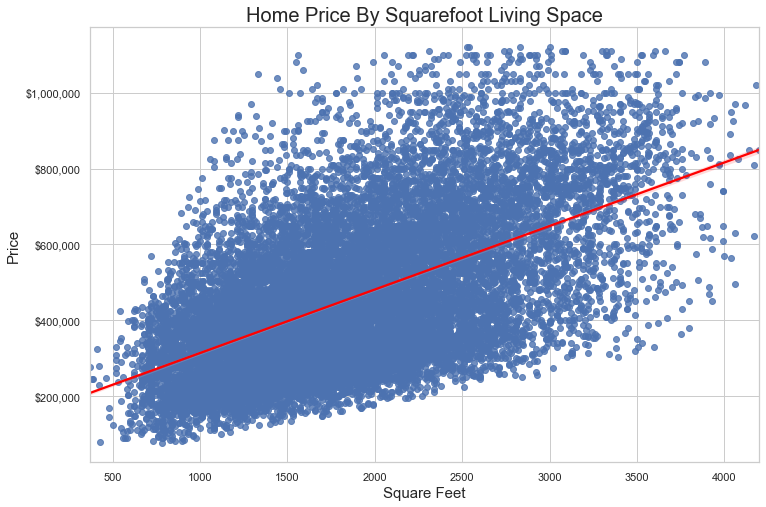

In [125]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(model4_df['sqft_living'], model4_df['price'], 
            line_kws={'color':'red'})

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Square Feet', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Home Price By Squarefoot Living Space', fontsize=20);

#### Increase number of bathrooms to increase price

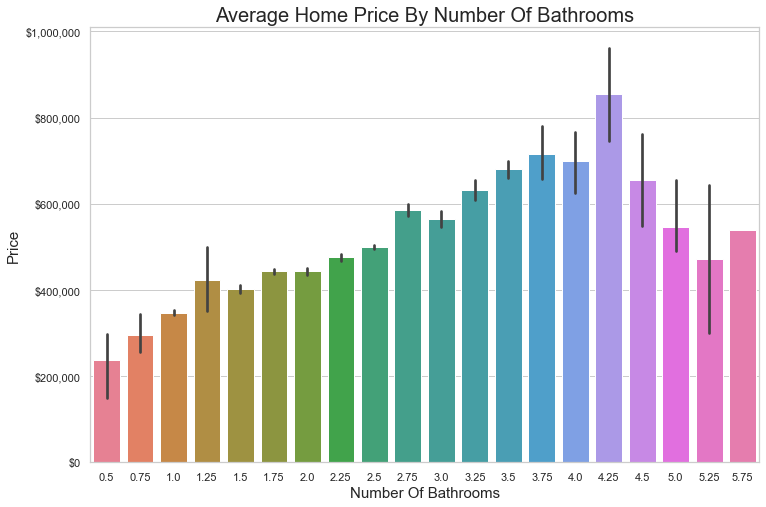

In [126]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='bathrooms', y='price', data=model4_df, palette="husl")

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Number Of Bathrooms', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Average Home Price By Number Of Bathrooms', fontsize=20);

#### Seek to increase home grade to increase price

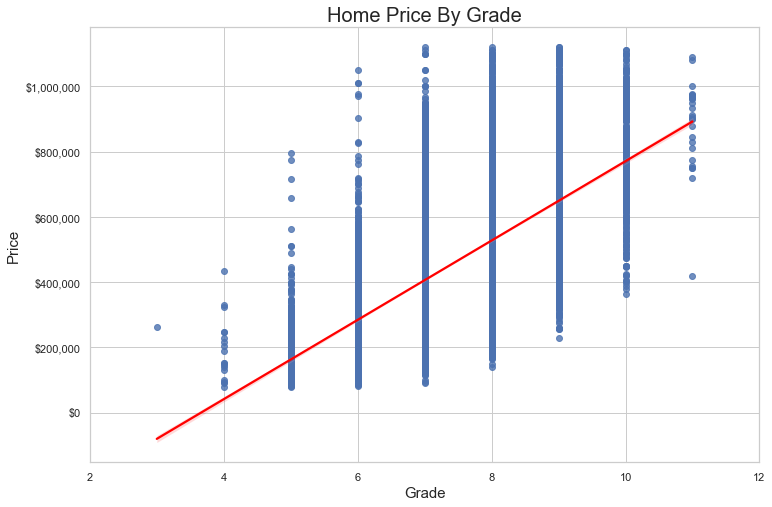

In [127]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(model4_df['grade'], model4_df['price'], line_kws={'color':'red'})

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting the range of the x-ticks
ax.set(xlim=(2, 12))

# Setting title and labels
ax.set_xlabel('Grade', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Home Price By Grade', fontsize=20);

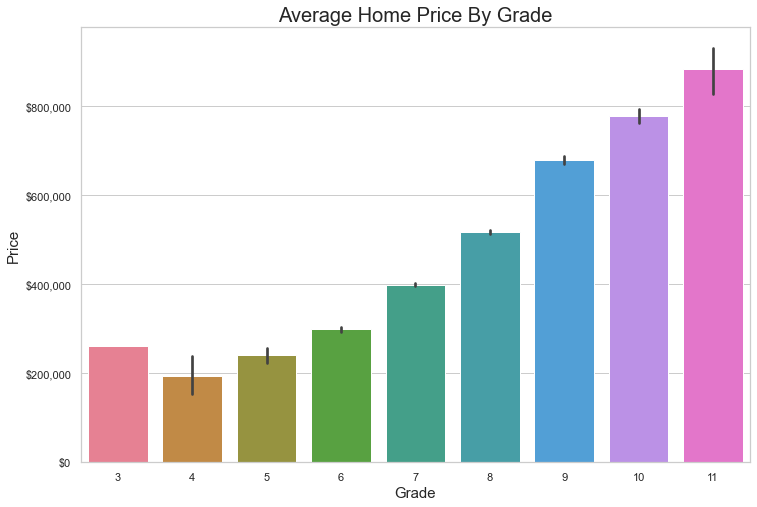

In [128]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='grade', y='price', data=model4_df, palette="husl")

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Grade', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Average Home Price By Grade', fontsize=20);

#### Seek to increase home condition to increase price

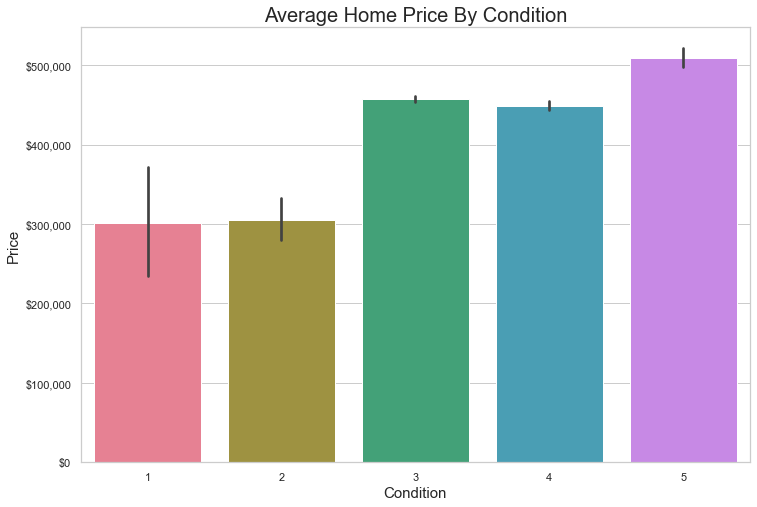

In [129]:
# Setting a figure size and plotting
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='condition', y='price', data=model4_df, palette="husl")

# Formatting the y-axis ticks to show as money
fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.yaxis.set_major_formatter(tick_money)

# Setting title and labels
ax.set_xlabel('Condition', fontsize=15)
ax.set_ylabel('Price', fontsize=15)
ax.set_title('Average Home Price By Condition', fontsize=20);

## Future directions

1. Stepwise feature selection - If I were to keep working with this data set I would try taking the perspective of doing a step wise feature selection. It would be interesting to see if such an approach from the beginning would improve model quality and/or residuals.

2. Scaling the data - If I were to keep working, I could try another iteration of the model where I scaled features. I briefly dabbled with transforming feature values to z-scores and it did seem to improve residual normality but greatly reduced the R squared. It would be an interesting experiment to try different methods of scaling or transforming the data to see what worked best and how the model changed.